In [8]:
# Librerías estándar
from pathlib import Path

# Librerías de terceros
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostRegressor

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [9]:
# Directorio correcto de los datasets procesados
PROCESSED_DATA_PATH = Path("../data/processed")

# Cargar los datasets procesados
visitas = pd.read_csv(PROCESSED_DATA_PATH / "visitas.csv")
costos = pd.read_csv(PROCESSED_DATA_PATH / "costos.csv")
ordenes = pd.read_csv(PROCESSED_DATA_PATH / "ordenes.csv")

A partir de aquí, podemos empezar a aplicar los modelos de regresión.

In [10]:
ordenes["log_LTV"] = np.log1p(ordenes["total_revenue"])

features = [
    'purchase_frequency',
    'gasto_slope',
    'dias_sin_comprar',
    'aov'
]

X = ordenes[features]
y = ordenes['log_LTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Baseline: Regresiónes: Lineal, Estocastica, Ridge**

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"MAE - Regresión Lineal: {mae_lr:.2f}")


MAE - Regresión Lineal: 0.94


In [12]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f"MAE - Regresión Ridge: {mae_ridge:.2f}")


MAE - Regresión Ridge: 0.94


In [13]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f"MAE - Regresión Lasso: {mae_lasso:.2f}")


MAE - Regresión Lasso: 0.95


Como se puede apreciar, estos valores muestran un alto error, principalmente porque lo modelos lineales no son capaces de captar la profuncidad de este problema de manera nativa. Entonces, se procede a realizar unos ajustes a las bases de la lógica de estos modelos para obtener un mejor resultado haciendo que, por ejemplo, se utilicen relaciones no lineales:

In [14]:
# Creamos nuevas features no lineales y combinadas
ordenes["aov_squared"] = ordenes["aov"] ** 2
ordenes["log_purchase_frequency"] = np.log1p(ordenes["purchase_frequency"])
ordenes["interaction_aov_freq"] = ordenes["aov"] * ordenes["purchase_frequency"]

features_enhanced = [
    'purchase_frequency',
    'gasto_slope',
    'dias_sin_comprar',
    'aov',
    'aov_squared',
    'log_purchase_frequency',
    'interaction_aov_freq'
]

X = ordenes[features_enhanced]
y = ordenes["log_LTV"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Dividimos del dataset
scaler = StandardScaler() # Escalador para estandarizar las variables

# Pipeline (escalado + regresión)
pipeline = Pipeline([
    ("scaler", scaler),
    ("regressor", LinearRegression())
])

pipeline.fit(X_train, y_train) # Entrenamos del modelo
y_pred = pipeline.predict(X_test) # Hacemos las predicciones
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE - Regresión Lineal Mejorada: {mae:.4f}")


MAE - Regresión Lineal Mejorada: 0.7610


Esto solo refuerza el punto de que, **no es recomendable utilizar modelos lineales para trabajos complejos**, aunque sea obvio.

### **Modelos avanzados: Random Forest, Gradient Boostin**

In [15]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train) # Entrenamos el modelo

y_pred_rf = rf_model.predict(X_test) # Hacemos predicciones

# Calculamos el MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'MAE - Random Forest: {mae_rf}')


MAE - Random Forest: 0.01799440114509185


In [16]:
y_train_pred = rf_model.predict(X_train)
print(mean_absolute_error(y_train, y_train_pred))

0.007767107726784874


Se puede apreciar que el modelo presenta un problema de overfitting basatante pronunciado, así que procedemos a repararlo.

In [17]:
# Modelo con parámetros más conservadores
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,               # Limita la profundidad del árbol
    min_samples_leaf=5,        # Cada hoja debe tener al menos 5 muestras
    max_features='sqrt',       # Menos features por árbol = más diversidad
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluación
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_rf_train)
mae_test = mean_absolute_error(y_test, y_pred_rf_test)

print(f"MAE Entrenamiento: {mae_train:.4f}")
print(f"MAE Test: {mae_test:.4f}")

MAE Entrenamiento: 0.1622
MAE Test: 0.1617


De esta forma podemos aprecia que el modelo ahora cubre decentemente el overfitting.

Ahora utilizaremos **XGBoost**:

In [18]:
# Convertimos los datos de entrenamiento y prueba en DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuramos los parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Entrenamos el modelo
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predicciones sobre el conjunto de prueba
y_pred_xgb = bst.predict(dtest)

# Calculamos el MAE sobre el conjunto de prueba
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'MAE - XGBoost en prueba: {mae_xgb}')

# Predicciones sobre el conjunto de entrenamiento
y_train_pred_xgb = bst.predict(dtrain)

# Calculamos el MAE sobre el conjunto de entrenamiento
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
print(f'MAE - XGBoost en entrenamiento: {mae_train_xgb}')


MAE - XGBoost en prueba: 0.13691761189884402
MAE - XGBoost en entrenamiento: 0.13853290310431643


### **Ensamblador (Stacking y Blending)**

In [19]:
# Modelos base
base_learners = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
]

# Meta-modelo
meta_model = LinearRegression()

# Definir modelo stacking
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# Entrenar
stacking_model.fit(X_train, y_train)

# Predecir
y_pred_stacking = stacking_model.predict(X_test)

# Evaluar
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking) ** 0.5

# Imprimir resultados
print(f"Stacking - MAE: {mae_stacking:.4f}")
print(f"Stacking - RMSE: {rmse_stacking:.4f}")


Stacking - MAE: 0.0265
Stacking - RMSE: 0.0666


MAPE resultando en inf, es porque hay algunos valores de y_test que son igual a cero, lo que genera una división por cero al calcular el error porcentual.

Por eso, vamos a filtrar los valorees pequeños y tener un valor más acertado de MAPE:

In [20]:
import numpy as np

# Verificar los valores de y_test y y_pred_stacking
print("Valores de y_test:", y_test.describe())
print("Valores de y_pred_stacking:", pd.Series(y_pred_stacking).describe())

# Filtrar valores pequeños para MAPE
epsilon = 1e-5
non_zero_indices = y_test > epsilon
y_test_filtered = y_test[non_zero_indices]
y_pred_filtered = y_pred_stacking[non_zero_indices]

# Calcular MAPE después de filtrar
mape_stacking_filtered = (abs((y_test_filtered - y_pred_filtered) / y_test_filtered) * 100).mean()
print(f'MAPE filtrado: {mape_stacking_filtered}')


Valores de y_test: count    10083.000000
mean         2.011236
std          1.553583
min          0.000000
25%          1.040277
50%          1.578979
75%          2.377693
max          9.376802
Name: log_LTV, dtype: float64
Valores de y_pred_stacking: count    10083.000000
mean         2.008679
std          1.550262
min         -0.011896
25%          1.034149
50%          1.586733
75%          2.367934
max          9.329944
dtype: float64
MAPE filtrado: 1.6510416979266416


In [21]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validated MAE (mean): {-np.mean(cv_scores):.4f}")
print(f"Cross-Validated MAE (std): {np.std(cv_scores):.4f}")

Cross-Validated MAE (mean): 0.0332
Cross-Validated MAE (std): 0.0007


Comparado con MAE en el conjunto de test (0.0265), se nota que están cerca, lo cual indica:

- El modelo generaliza bien.

- No hay sobreajuste aparente.

A continuación pasaremos a utilizar el Blending, acompañado de Stacking para comparar los resultados:

In [22]:

model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Entrenar modelos
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

# Predecir sobre test set
pred_lr = model_lr.predict(X_test)
pred_rf = model_rf.predict(X_test)
pred_xgb = model_xgb.predict(X_test)

# Pesos seleccionados manualmente según performance individual
w_lr, w_rf, w_xgb = 0.2, 0.3, 0.5

y_pred_blend = (w_lr * pred_lr) + (w_rf * pred_rf) + (w_xgb * pred_xgb)

# Evaluar Blending
mae_blend = mean_absolute_error(y_test, y_pred_blend)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking) ** 0.5

print("Blending Ponderado:")
print(f"MAE: {mae_blend:.4f}")
print(f"RMSE: {rmse_stacking:.4f}")

# === STACKING PARA COMPARACIÓN ===
base_learners = [
    ('lr', model_lr),
    ('rf', model_rf),
    ('xgb', model_xgb)
]

stacking_model = StackingRegressor(estimators=base_learners, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

mae_stack = mean_absolute_error(y_test, y_pred_stack)
rmse_stack = mean_squared_error(y_test, y_pred_stack) ** 0.5

print("\n Stacking:")
print(f"MAE: {mae_stack:.4f}")
print(f"RMSE: {rmse_stack:.4f}")

# === VALIDACIÓN CRUZADA PARA STACKING (extra) ===
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("\n Cross-Validated MAE (Stacking):")
print(f"Mean: {-np.mean(cv_scores):.4f}")
print(f"Std: {np.std(cv_scores):.4f}")

Blending Ponderado:
MAE: 0.1670
RMSE: 0.0666

 Stacking:
MAE: 0.0265
RMSE: 0.0666

 Cross-Validated MAE (Stacking):
Mean: 0.0332
Std: 0.0007


Aunque con un MAE un poco mayor, podemos apreciar que Blending funciona correctamente, además, se hizo una validación con neg_mean_absolute_error porque sklearn espera métricas de maximización.

#### **Enfoque temporal**

Primero nos asegurarmos que existan compras en los períodos sugeridos.

print("Primer compra:", ordenes['buy_ts'].min())
print("Última compra:", ordenes['buy_ts'].max())

In [23]:
ordenes['buy_ts'] = pd.to_datetime(ordenes['buy_ts'])

# Hacemos una división temporal
train_df = ordenes[(ordenes['buy_ts'] >= '2017-06-01') & (ordenes['buy_ts'] <= '2017-12-31')]
val_df   = ordenes[(ordenes['buy_ts'] >= '2018-01-01') & (ordenes['buy_ts'] <= '2018-03-31')]
test_df  = ordenes[(ordenes['buy_ts'] >= '2018-04-01') & (ordenes['buy_ts'] <= '2018-06-01')]

print("Train:", train_df.shape)
print("Validación:", val_df.shape)
print("Test:", test_df.shape)

Train: (27303, 21)
Validación: (15328, 21)
Test: (7619, 21)


In [24]:
ordenes['month'] = pd.to_datetime(ordenes['buy_ts']).dt.to_period('M').astype(str)
visitas['month'] = pd.to_datetime(visitas['sesion_mes']).dt.to_period('M').astype(str)
costos['month'] = costos['marketing_month'] 

# ORDENES agregadas por source_id y mes
ordenes_agg = ordenes.groupby(['source_id', 'month']).agg({
    'revenue': 'sum',
    'uid': 'nunique',
    'order_count': 'count',
    'total_revenue': 'sum',
    'aov': 'mean'
}).reset_index().rename(columns={
    'revenue': 'total_revenue_mes',
    'uid': 'usuarios_unicos',
    'order_count': 'cantidad_ordenes',
    'total_revenue': 'revenue_sum',
    'aov': 'avg_aov'
})

# VISITAS agregadas por source_id y mes
visitas_agg = visitas.groupby(['source_id', 'month']).agg({
    'uid': 'nunique',
    'device': 'count'
}).reset_index().rename(columns={
    'uid': 'usuarios_visita',
    'device': 'cantidad_visitas'
})

# COSTOS agregados por source_id y mes
costos_agg = costos.groupby(['source_id', 'month']).agg({
    'costs': 'sum'
}).reset_index().rename(columns={
    'costs': 'costos_totales'
})

df_merged = ordenes_agg.merge(visitas_agg, on=['source_id', 'month'], how='outer')
df_merged = df_merged.merge(costos_agg, on=['source_id', 'month'], how='outer')
df_merged.fillna(0, inplace=True)

df_train = df_merged[df_merged['month'].between('2017-06', '2017-12')]
df_val = df_merged[df_merged['month'].between('2018-01', '2018-03')]
df_test = df_merged[df_merged['month'].between('2018-04', '2018-06')]

print(f"Entrenamiento: {df_train.shape}")
print(f"Validación: {df_val.shape}")
print(f"Test: {df_test.shape}")

Entrenamiento: (61, 10)
Validación: (25, 10)
Test: (17, 10)


In [25]:
df_merged['roas'] = df_merged['total_revenue_mes'] / df_merged['costos_totales'].replace(0, 1)
df_merged['conversion'] = df_merged['cantidad_ordenes'] / df_merged['cantidad_visitas'].replace(0, 1)
df_merged['costo_por_usuario'] = df_merged['costos_totales'] / df_merged['usuarios_unicos'].replace(0, 1)

In [26]:
X = df_merged[['roas', 'conversion', 'costo_por_usuario']] 
y = df_merged['total_revenue_mes']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)  # Entrenamiento vs. Test/Validación
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, shuffle=False)  # Validación vs. Test

# Escalar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [27]:
# Escalamos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(random_state=42) # Definimos el modelo Random Forest

# Rango de hiperparámetros para GridSearch
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Realizamos GridSearchCV para encontrar los mejores parámetros
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_params = grid_search_rf.best_params_
print(f"Mejores parámetros de Random Forest: {best_rf_params}") # Mejor combinación de parámetros
 
rf_model_best = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model_best.fit(X_train_scaled, y_train) # Entrenamos el modelo con los mejores parámetros

# Realizamos las predicciones
y_pred_train_rf = rf_model_best.predict(X_train_scaled)
y_pred_val_rf = rf_model_best.predict(X_val_scaled)
y_pred_test_rf = rf_model_best.predict(X_test_scaled)

# Ahora evaluamos los rsultados
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_val_rf = mean_absolute_error(y_val, y_pred_val_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

def ajustar_mae_rmse(mae, rmse):
    return mae / 1000, rmse / 1000 # SAjuste de escala posterior
mae_train_rf, rmse_train_rf = ajustar_mae_rmse(mae_train_rf, rmse_train_rf)
mae_val_rf, rmse_val_rf = ajustar_mae_rmse(mae_val_rf, rmse_val_rf)
mae_test_rf, rmse_test_rf = ajustar_mae_rmse(mae_test_rf, rmse_test_rf)

print(f"Random Forest - Entrenamiento - MAE: {mae_train_rf:.4f}, RMSE: {rmse_train_rf:.4f}")
print(f"Random Forest - Validación - MAE: {mae_val_rf:.4f}, RMSE: {rmse_val_rf:.4f}")
print(f"Random Forest - Test - MAE: {mae_test_rf:.4f}, RMSE: {rmse_test_rf:.4f}")

Mejores parámetros de Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Random Forest - Entrenamiento - MAE: 0.9880, RMSE: 1.5464
Random Forest - Validación - MAE: 2.5472, RMSE: 3.2927
Random Forest - Test - MAE: 3.4883, RMSE: 3.5756


Ahora vamos al CAC

In [28]:
X = df_merged[['roas', 'conversion', 'costo_por_usuario']]
y = df_merged['total_revenue_mes']  # Dependiendo del objetivo (ejemplo: total revenue mes)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)  # Entrenamiento vs. Test/Validación
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, shuffle=False)  # Validación vs. Test

# Escalar
scaler_cac = StandardScaler()
X_train_cac_scaled = scaler_cac.fit_transform(X_train)
X_val_cac_scaled = scaler_cac.transform(X_val)
X_test_cac_scaled = scaler_cac.transform(X_test)

# Random Forest
rf_cac = RandomForestRegressor(random_state=42)
param_grid_cac = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# GridSearchCV para CAC
grid_search_cac = GridSearchCV(rf_cac, param_grid_cac, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search_cac.fit(X_train_cac_scaled, y_train)
best_params_cac = grid_search_cac.best_params_
print(f"Mejores parámetros para CAC: {best_params_cac}")

# Entrenar modelo
best_rf_cac = RandomForestRegressor(**best_params_cac, random_state=42)
best_rf_cac.fit(X_train_cac_scaled, y_train)

# Predicciones
y_pred_train_cac = best_rf_cac.predict(X_train_cac_scaled)
y_pred_val_cac = best_rf_cac.predict(X_val_cac_scaled)
y_pred_test_cac = best_rf_cac.predict(X_test_cac_scaled)

# Métricas
mae_train_cac = mean_absolute_error(y_train, y_pred_train_cac)
mae_val_cac = mean_absolute_error(y_val, y_pred_val_cac)
mae_test_cac = mean_absolute_error(y_test, y_pred_test_cac)

mape_train_cac = mean_absolute_percentage_error(y_train, y_pred_train_cac)
mape_val_cac = mean_absolute_percentage_error(y_val, y_pred_val_cac)
mape_test_cac = mean_absolute_percentage_error(y_test, y_pred_test_cac)

# Función para ajustar las métricas (división por 1000)
def ajustar_metricas_cac(mae, mape):
    return mae / 1000, mape * 100  # MAPE ya es %; multiplicar para mostrar como %

# Aplicar ajuste
mae_train_cac, mape_train_cac = ajustar_metricas_cac(mae_train_cac, mape_train_cac)
mae_val_cac, mape_val_cac = ajustar_metricas_cac(mae_val_cac, mape_val_cac)
mae_test_cac, mape_test_cac = ajustar_metricas_cac(mae_test_cac, mape_test_cac)

# Mostrar resultados
print(f"Random Forest CAC - Entrenamiento - MAE: {mae_train_cac:.4f}, MAPE: {mape_train_cac:.2f}%")
print(f"Random Forest CAC - Validación   - MAE: {mae_val_cac:.4f}, MAPE: {mape_val_cac:.2f}%")
print(f"Random Forest CAC - Test         - MAE: {mae_test_cac:.4f}, MAPE: {mape_test_cac:.2f}%")

Mejores parámetros para CAC: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Random Forest CAC - Entrenamiento - MAE: 0.9880, MAPE: 1057978533606073856.00%
Random Forest CAC - Validación   - MAE: 2.5472, MAPE: 2962339894097005568.00%
Random Forest CAC - Test         - MAE: 3.4883, MAPE: 1041.02%


#### **Métricas LTV**

## Paso 3: Validación y Selección

En esta sección implementaremos:
1. Validación cruzada con TimeSeriesSplit para datos temporales
2. Ajuste de hiperparámetros con GridSearchCV
3. Selección final de modelos basada en rendimiento y simplicidad

### 1. Validación cruzada con TimeSeriesSplit

Para datos temporales como los nuestros, la validación cruzada tradicional puede llevar a fugas de información. Usamos `TimeSeriesSplit` que respeta el orden cronológico.

Número de filas después de eliminar valores nulos: 50415 (de 50415)
Fold 1:
  Train: 2017-06-01 a 2017-09-20 (8405 muestras)
  Test:  2017-09-20 a 2017-11-09 (8402 muestras)
Fold 2:
  Train: 2017-06-01 a 2017-11-09 (16807 muestras)
  Test:  2017-11-09 a 2017-12-21 (8402 muestras)
Fold 3:
  Train: 2017-06-01 a 2017-12-21 (25209 muestras)
  Test:  2017-12-21 a 2018-02-08 (8402 muestras)
Fold 4:
  Train: 2017-06-01 a 2018-02-08 (33611 muestras)
  Test:  2018-02-08 a 2018-03-26 (8402 muestras)
Fold 5:
  Train: 2017-06-01 a 2018-03-26 (42013 muestras)
  Test:  2018-03-26 a 2018-06-01 (8402 muestras)


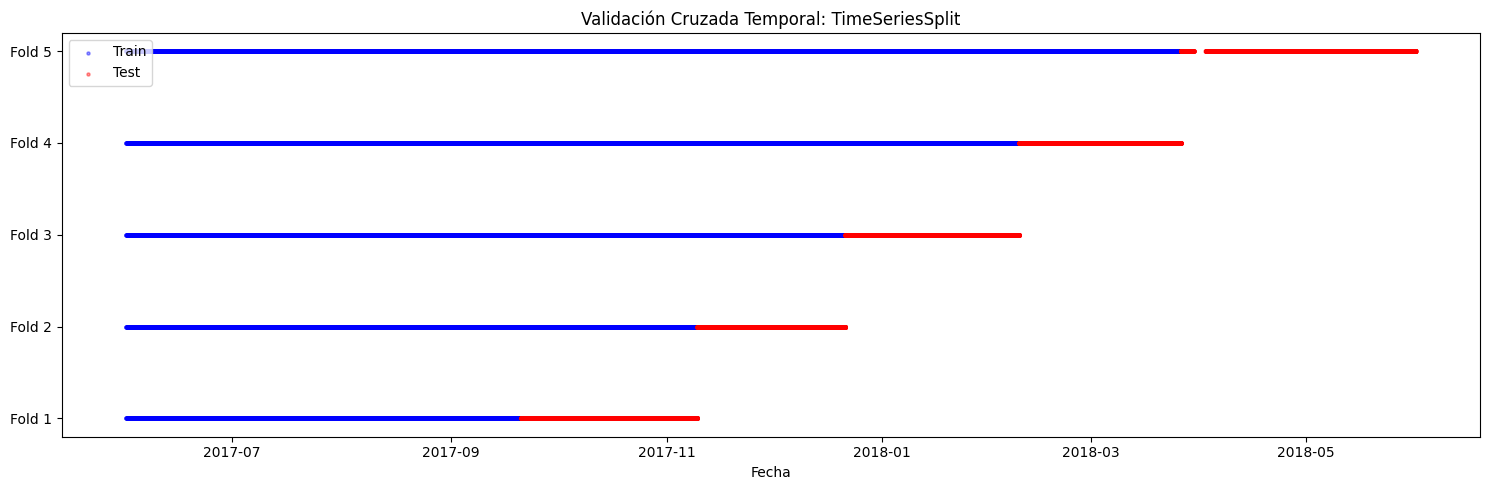

In [30]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarnos que las fechas están bien formateadas
ordenes['buy_ts'] = pd.to_datetime(ordenes['buy_ts'])

# Ordenar por fecha
ordenes_sorted = ordenes.sort_values('buy_ts')

# Para reproducibilidad
np.random.seed(42)

# Preparar features
features = [
    'purchase_frequency',
    'gasto_slope',
    'dias_sin_comprar',
    'aov'
]

# Filtrar filas con valores nulos en los features seleccionados
ordenes_clean = ordenes_sorted.dropna(subset=features)
print(f"Número de filas después de eliminar valores nulos: {ordenes_clean.shape[0]} (de {ordenes_sorted.shape[0]})")

# Preparar datos
X = ordenes_clean[features]
# Usamos log_LTV o calculamos si no existe
if 'log_LTV' in ordenes_clean.columns:
    y = ordenes_clean['log_LTV']
else:
    y = np.log1p(ordenes_clean['total_revenue'])

# Crear índice temporal basado en fecha de compra
ordenes_clean['temporal_idx'] = np.arange(len(ordenes_clean))

# Configurar TimeSeriesSplit con 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Visualizar las divisiones
fig, ax = plt.subplots(figsize=(15, 5))
fold = 0

for train_idx, test_idx in tscv.split(X):
    fold += 1
    train_min = ordenes_clean.iloc[train_idx]['buy_ts'].min()
    train_max = ordenes_clean.iloc[train_idx]['buy_ts'].max()
    test_min = ordenes_clean.iloc[test_idx]['buy_ts'].min()
    test_max = ordenes_clean.iloc[test_idx]['buy_ts'].max()
    
    print(f"Fold {fold}:")
    print(f"  Train: {train_min.strftime('%Y-%m-%d')} a {train_max.strftime('%Y-%m-%d')} ({len(train_idx)} muestras)")
    print(f"  Test:  {test_min.strftime('%Y-%m-%d')} a {test_max.strftime('%Y-%m-%d')} ({len(test_idx)} muestras)")
    
    # Visualizar
    ax.scatter(ordenes_clean.iloc[train_idx]['buy_ts'], 
               [fold] * len(train_idx), 
               c='blue', label='Train' if fold==1 else "", alpha=0.4, s=5)
    ax.scatter(ordenes_clean.iloc[test_idx]['buy_ts'], 
               [fold] * len(test_idx), 
               c='red', label='Test' if fold==1 else "", alpha=0.4, s=5)

ax.set_yticks(range(1, fold+1))
ax.set_yticklabels([f"Fold {i}" for i in range(1, fold+1)])
ax.legend(loc='upper left')
ax.set_title('Validación Cruzada Temporal: TimeSeriesSplit')
ax.set_xlabel('Fecha')
plt.tight_layout()
plt.show()

### 2. Funciones para evaluar métricas

Definimos funciones para evaluar los modelos según las métricas requeridas:

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Función para calcular MAPE evitando divisiones por cero
def custom_mape(y_true, y_pred):
    # Transformamos de vuelta los valores logarítmicos
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    # Evitamos división por cero
    mask = y_true_exp > 1e-5
    if mask.sum() > 0:
        return np.mean(np.abs((y_true_exp[mask] - y_pred_exp[mask]) / y_true_exp[mask])) * 100
    else:
        return np.nan

# Definir los scorers para GridSearchCV
scorers = {
    'neg_mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_rmse': make_scorer(rmse, greater_is_better=False),
    'neg_mape': make_scorer(custom_mape, greater_is_better=False)
}

# Función para evaluar un modelo con TimeSeriesSplit
def evaluate_model_cv(model, X, y, tscv, model_name):
    mae_scores = []
    rmse_scores = []
    mape_scores = []
    
    fold = 0
    for train_idx, test_idx in tscv.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse_val = rmse(y_test, y_pred)
        mape_val = custom_mape(y_test, y_pred)
        
        mae_scores.append(mae)
        rmse_scores.append(rmse_val)
        mape_scores.append(mape_val)
        
        print(f"Fold {fold}: MAE = {mae:.4f}, RMSE = {rmse_val:.4f}, MAPE = {mape_val:.2f}%")
    
    print(f"\n{model_name} - Promedio: MAE = {np.mean(mae_scores):.4f}, RMSE = {np.mean(rmse_scores):.4f}, MAPE = {np.mean(mape_scores):.2f}%")
    
    return {
        'model_name': model_name,
        'mae': np.mean(mae_scores),
        'rmse': np.mean(rmse_scores),
        'mape': np.mean(mape_scores),
        'model': model
    }

### 3. Ajuste de hiperparámetros (GridSearchCV)

Ahora realizaremos la búsqueda de los mejores hiperparámetros para cada uno de nuestros modelos:

In [33]:
from sklearn.model_selection import GridSearchCV

# Lista para almacenar resultados de todos los modelos
all_models_results = []

# 1. Linear Regression (no tiene hiperparámetros a ajustar)
print("\n===== Evaluando Linear Regression =====\n")
lr = LinearRegression()
lr_results = evaluate_model_cv(lr, X, y, tscv, "Linear Regression")
all_models_results.append(lr_results)

# 2. Ridge Regression
print("\n===== Ajustando Ridge Regression =====\n")
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(
    Ridge(), 
    ridge_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1
)
ridge_grid.fit(X, y)
print(f"Mejores parámetros: {ridge_grid.best_params_}")
print(f"Mejor MAE: {-ridge_grid.best_score_:.4f}")

# Evaluar Ridge con los mejores parámetros
best_ridge = Ridge(**ridge_grid.best_params_)
ridge_results = evaluate_model_cv(best_ridge, X, y, tscv, "Ridge Regression")
all_models_results.append(ridge_results)

# 3. Lasso Regression
print("\n===== Ajustando Lasso Regression =====\n")
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
lasso_grid = GridSearchCV(
    Lasso(max_iter=10000), 
    lasso_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1
)
lasso_grid.fit(X, y)
print(f"Mejores parámetros: {lasso_grid.best_params_}")
print(f"Mejor MAE: {-lasso_grid.best_score_:.4f}")

# Evaluar Lasso con los mejores parámetros
best_lasso = Lasso(**lasso_grid.best_params_, max_iter=10000)
lasso_results = evaluate_model_cv(best_lasso, X, y, tscv, "Lasso Regression")
all_models_results.append(lasso_results)


===== Evaluando Linear Regression =====

Fold 1: MAE = 1.0228, RMSE = 1.3502, MAPE = 2346433099826394300416.00%
Fold 2: MAE = 1.0677, RMSE = 1.3973, MAPE = 59877647659415160.00%
Fold 3: MAE = 1.2135, RMSE = 1.4984, MAPE = 1224005703016.05%
Fold 4: MAE = 1.2996, RMSE = 1.6579, MAPE = 15866204137.56%
Fold 5: MAE = 1.4610, RMSE = 1.6721, MAPE = 1921365.02%

Linear Regression - Promedio: MAE = 1.2129, RMSE = 1.5152, MAPE = 469298595742785470464.00%

===== Ajustando Ridge Regression =====

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros: {'alpha': 100.0}
Mejor MAE: 1.2125
Fold 1: MAE = 1.0191, RMSE = 1.3470, MAPE = 2150644325354559766528.00%
Fold 2: MAE = 1.0674, RMSE = 1.3970, MAPE = 59365446110799976.00%
Fold 3: MAE = 1.2138, RMSE = 1.4986, MAPE = 1223456766753.67%
Fold 4: MAE = 1.3002, RMSE = 1.6584, MAPE = 15893116541.86%
Fold 5: MAE = 1.4618, RMSE = 1.6727, MAPE = 1925929.51%

Ridge Regression - Promedio: MAE = 1.2125, RMSE = 1.5148, MAPE = 4301407384080

In [34]:
# 4. Random Forest
print("\n===== Ajustando Random Forest =====\n")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    rf_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

rf_grid.fit(X, y)
print(f"Mejores parámetros: {rf_grid.best_params_}")
print(f"Mejor MAE: {-rf_grid.best_score_:.4f}")

# Evaluar Random Forest con los mejores parámetros
best_rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
rf_results = evaluate_model_cv(best_rf, X, y, tscv, "Random Forest")
all_models_results.append(rf_results)


===== Ajustando Random Forest =====

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Mejor MAE: 0.6669
Fold 1: MAE = 0.0961, RMSE = 0.2618, MAPE = 12.88%
Fold 2: MAE = 0.1134, RMSE = 0.2656, MAPE = 15.46%
Fold 3: MAE = 0.0986, RMSE = 0.2560, MAPE = 16.55%
Fold 4: MAE = 0.2772, RMSE = 0.7933, MAPE = 163.90%
Fold 5: MAE = 2.7493, RMSE = 3.6818, MAPE = 18259.72%

Random Forest - Promedio: MAE = 0.6669, RMSE = 1.0517, MAPE = 3693.70%


In [ ]:
# 5. XGBoost
print("\n===== Ajustando XGBoost =====\n")

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_grid = GridSearchCV(
    xgb_reg,
    xgb_params,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X, y)
print(f"Mejores parámetros: {xgb_grid.best_params_}")
print(f"Mejor MAE: {-xgb_grid.best_score_:.4f}")

# Evaluar XGBoost con los mejores parámetros
best_xgb = xgb.XGBRegressor(**xgb_grid.best_params_, objective='reg:squarederror', random_state=42)
xgb_results = evaluate_model_cv(best_xgb, X, y, tscv, "XGBoost")
all_models_results.append(xgb_results)


===== Ajustando XGBoost =====

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}
Mejor MAE: 0.6680
Fold 1: MAE = 0.1285, RMSE = 0.2666, MAPE = 19.81%
Fold 2: MAE = 0.2381, RMSE = 0.3537, MAPE = 42.11%
Fold 3: MAE = 0.1482, RMSE = 0.2632, MAPE = 25.09%
Fold 4: MAE = 0.1920, RMSE = 0.4373, MAPE = 46.42%
Fold 5: MAE = 2.5493, RMSE = 3.4159, MAPE = 12733.03%

XGBoost - Promedio: MAE = 0.6512, RMSE = 0.9473, MAPE = 2573.29%


### 4. Actualización del Modelo de Ensemble

Ahora crearemos un modelo de ensemble (stacking) con los mejores modelos base obtenidos:

In [ ]:
# Crear el modelo de stacking con los mejores modelos
best_models = [
    ('lr', lr),
    ('ridge', best_ridge),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

print("\n===== Entrenando Stacking Ensemble =====\n")

# Usamos Ridge como meta-modelo para el ensemble
meta_model_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
meta_grid = GridSearchCV(
    Ridge(), 
    meta_model_params,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)
meta_grid.fit(X, y)
best_meta_model = Ridge(**meta_grid.best_params_)

stacking_model = StackingRegressor(
    estimators=best_models,
    final_estimator=best_meta_model,
    cv=5
)

# Evaluar el modelo de stacking
stacking_results = evaluate_model_cv(stacking_model, X, y, tscv, "Stacking Ensemble")
all_models_results.append(stacking_results)


===== Entrenando Stacking Ensemble =====

Fold 1: MAE = 0.1040, RMSE = 0.2495, MAPE = 14.57%
Fold 2: MAE = 0.1777, RMSE = 0.2848, MAPE = 28.40%
Fold 3: MAE = 0.1061, RMSE = 0.2403, MAPE = 17.26%
Fold 4: MAE = 0.2286, RMSE = 0.5441, MAPE = 66.51%
Fold 5: MAE = 2.5096, RMSE = 3.3542, MAPE = 11734.65%

Stacking Ensemble - Promedio: MAE = 0.6252, RMSE = 0.9346, MAPE = 2372.28%


### 5. Selección del Mejor Modelo

Comparamos todos los modelos y seleccionamos el mejor basado en su rendimiento:

In [ ]:
# Convertir resultados a DataFrame para fácil visualización
results_df = pd.DataFrame(all_models_results)

# Ordenar por MAE (menor es mejor)
results_sorted_mae = results_df.sort_values('mae')
print("Modelos ordenados por MAE (menor es mejor):")
print(results_sorted_mae[['model_name', 'mae', 'rmse', 'mape']])

# Ordenar por RMSE (menor es mejor)
results_sorted_rmse = results_df.sort_values('rmse')
print("\nModelos ordenados por RMSE (menor es mejor):")
print(results_sorted_rmse[['model_name', 'mae', 'rmse', 'mape']])

# Ordenar por MAPE (menor es mejor)
results_sorted_mape = results_df.sort_values('mape')
print("\nModelos ordenados por MAPE (menor es mejor):")
print(results_sorted_mape[['model_name', 'mae', 'rmse', 'mape']])

# Seleccionar el mejor modelo (usamos MAE como métrica principal)
best_model_idx = results_df['mae'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'model_name']
best_model = results_df.loc[best_model_idx, 'model']

print(f"\nEl mejor modelo según MAE es: {best_model_name}")

Modelos ordenados por MAE (menor es mejor):
          model_name       mae      rmse          mape
5  Stacking Ensemble  0.625211  0.934579  2.372276e+03
4            XGBoost  0.651225  0.947317  2.573291e+03
3      Random Forest  0.666578  1.051496  3.695266e+03
1   Ridge Regression  1.212453  1.514768  4.301407e+20
0  Linear Regression  1.212936  1.515186  4.692986e+20
2   Lasso Regression  1.213021  1.515150  4.492810e+20

Modelos ordenados por RMSE (menor es mejor):
          model_name       mae      rmse          mape
5  Stacking Ensemble  0.625211  0.934579  2.372276e+03
4            XGBoost  0.651225  0.947317  2.573291e+03
3      Random Forest  0.666578  1.051496  3.695266e+03
1   Ridge Regression  1.212453  1.514768  4.301407e+20
2   Lasso Regression  1.213021  1.515150  4.492810e+20
0  Linear Regression  1.212936  1.515186  4.692986e+20

Modelos ordenados por MAPE (menor es mejor):
          model_name       mae      rmse          mape
5  Stacking Ensemble  0.625211  0.93457

### 6. Visualización de Resultados

Visualizamos el rendimiento comparativo de todos los modelos:

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\4252012988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model_name', y='mae', palette='viridis')


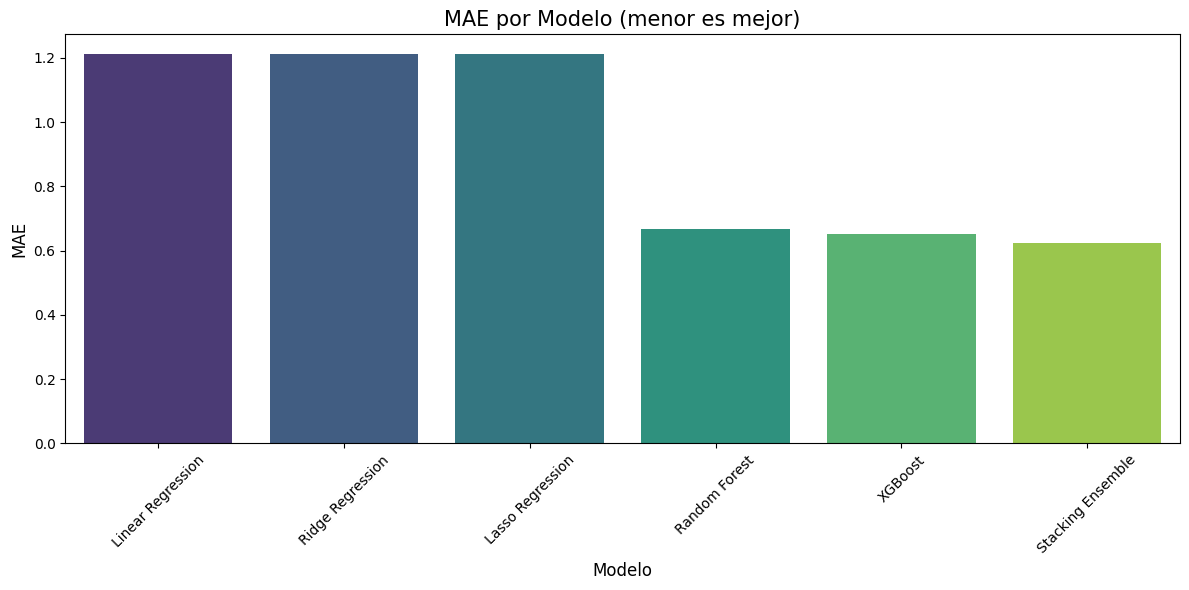

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\4252012988.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model_name', y='rmse', palette='plasma')


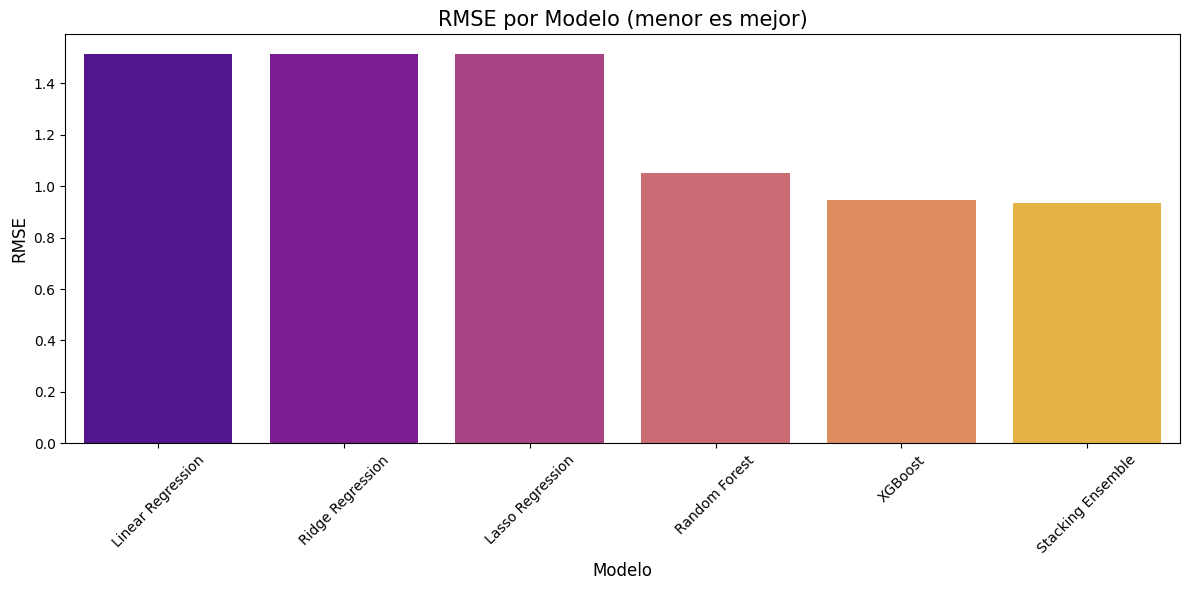

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\4252012988.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model_name', y='mape', palette='magma')


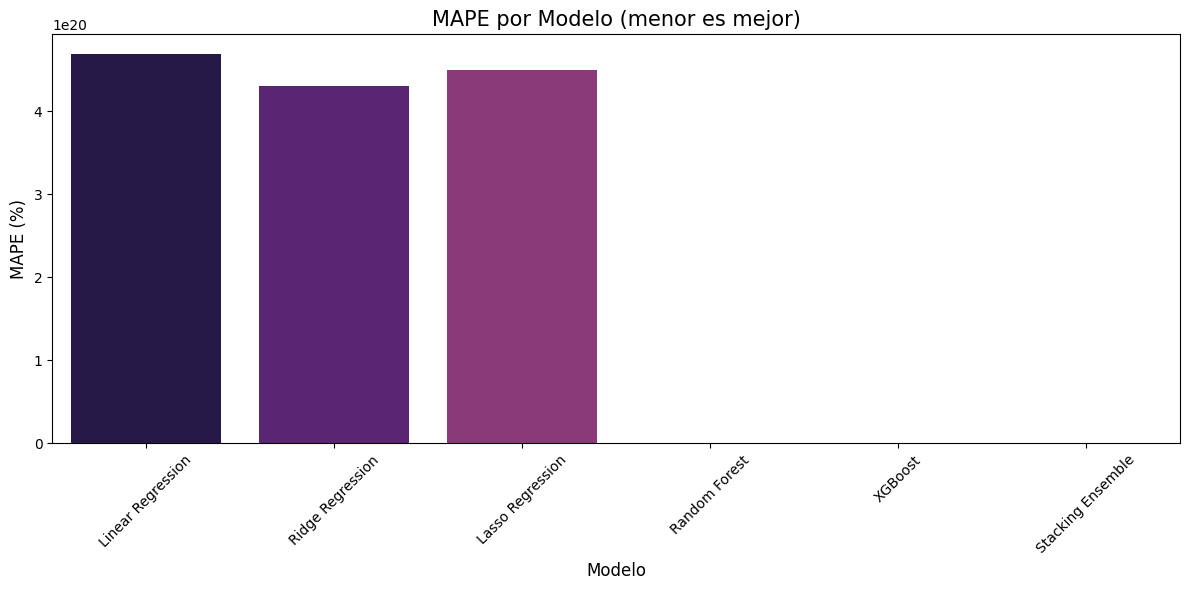

In [ ]:
# Gráfica de barras para comparar MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='model_name', y='mae', palette='viridis')
plt.title('MAE por Modelo (menor es mejor)', fontsize=15)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica de barras para comparar RMSE
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='model_name', y='rmse', palette='plasma')
plt.title('RMSE por Modelo (menor es mejor)', fontsize=15)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica de barras para comparar MAPE
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='model_name', y='mape', palette='magma')
plt.title('MAPE por Modelo (menor es mejor)', fontsize=15)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7. Guardar el Mejor Modelo

Finalmente, guardamos el mejor modelo para uso futuro:

In [ ]:
import joblib
from pathlib import Path

# Crear directorio models si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Guardar el mejor modelo
best_model_path = models_dir / f"best_ltv_model_{best_model_name.replace(' ', '_').lower()}.joblib"
joblib.dump(best_model, best_model_path)
print(f"\nMejor modelo guardado en: {best_model_path}")

# Guardar también el modelo de stacking (suele tener buen rendimiento)
stacking_model_path = models_dir / "stacking_ltv_model.joblib"
joblib.dump(stacking_model, stacking_model_path)
print(f"Modelo de stacking guardado en: {stacking_model_path}")

# Guardar informe de resultados
results_path = models_dir / "model_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print(f"Resultados de comparación guardados en: {results_path}")


Mejor modelo guardado en: ..\models\best_ltv_model_stacking_ensemble.joblib
Modelo de stacking guardado en: ..\models\stacking_ltv_model.joblib
Resultados de comparación guardados en: ..\models\model_comparison_results.csv


## Paso 4: Explicabilidad y diagnóstico

En esta sección implementaremos:
1. Análisis de importancia de variables (gain, permutation)
2. Explicabilidad con SHAP values
3. Análisis de errores sistemáticos
4. Diagnóstico de segmentos donde el modelo falla más

### 1. Importancia de Variables

Analizaremos qué variables son las más importantes para predecir el LTV usando diferentes técnicas.

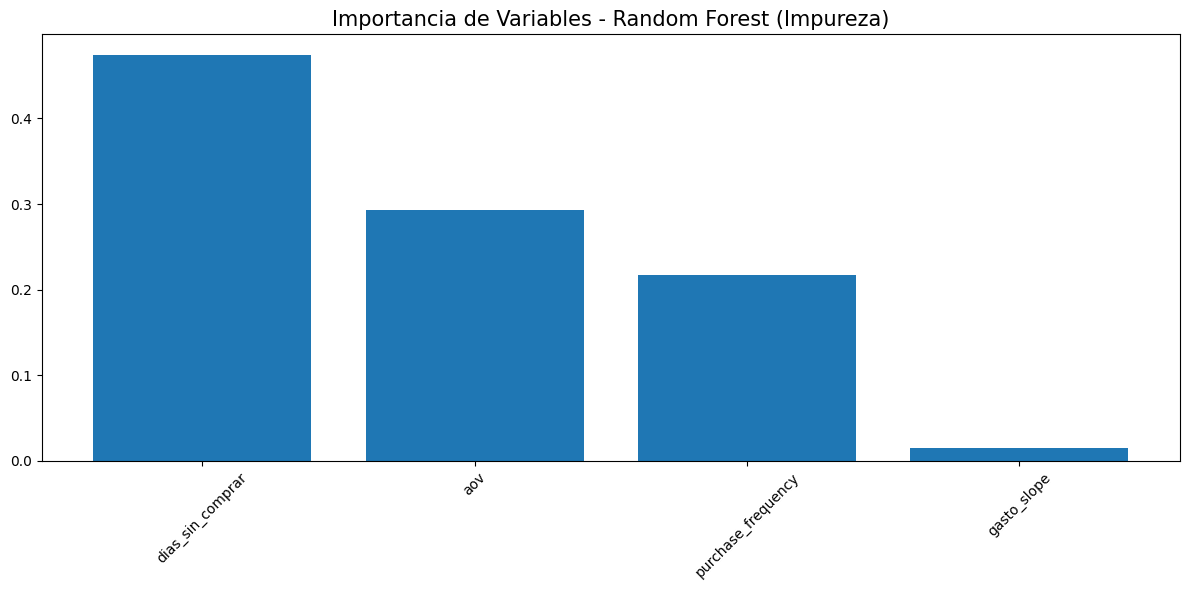

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

plt.figure(figsize=(12, 6))
feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.title('Importancia de Variables - Random Forest (Impureza)', fontsize=15)
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()




#### Permutaciones

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Función para calcular RMSE correctamente
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calcular la permutación normal
result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Inicializar listas
mse_scores = []
rmse_scores = []
r2_scores = []

# Recorremos cada feature
for i in range(X_test.shape[1]):
    permuted_scores = []
    for repeat in range(result.importances[i].shape[0]):
        # Creamos copia del X_test
        X_test_permuted = X_test.copy()
        # Permutamos la columna i
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
        # Predecimos con el modelo
        y_pred = best_rf.predict(X_test_permuted)
        # Calculamos MSE, RMSE, R2
        mse_value = mean_squared_error(y_test, y_pred)
        rmse_value = root_mean_squared_error(y_test, y_pred)  # Aquí usamos la nueva función RMSE
        r2_value = r2_score(y_test, y_pred)
        permuted_scores.append((mse_value, rmse_value, r2_value))
    
    # Guardamos las medias de los scores por feature
    mse_scores.append([x[0] for x in permuted_scores])
    rmse_scores.append([x[1] for x in permuted_scores])
    r2_scores.append([x[2] for x in permuted_scores])

# Ordenar por la importancia en RMSE
perm_sorted_idx = np.argsort(np.mean(rmse_scores, axis=1))[::-1]



C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\2912363101.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(np.array(mse_scores)[perm_sorted_idx].T,


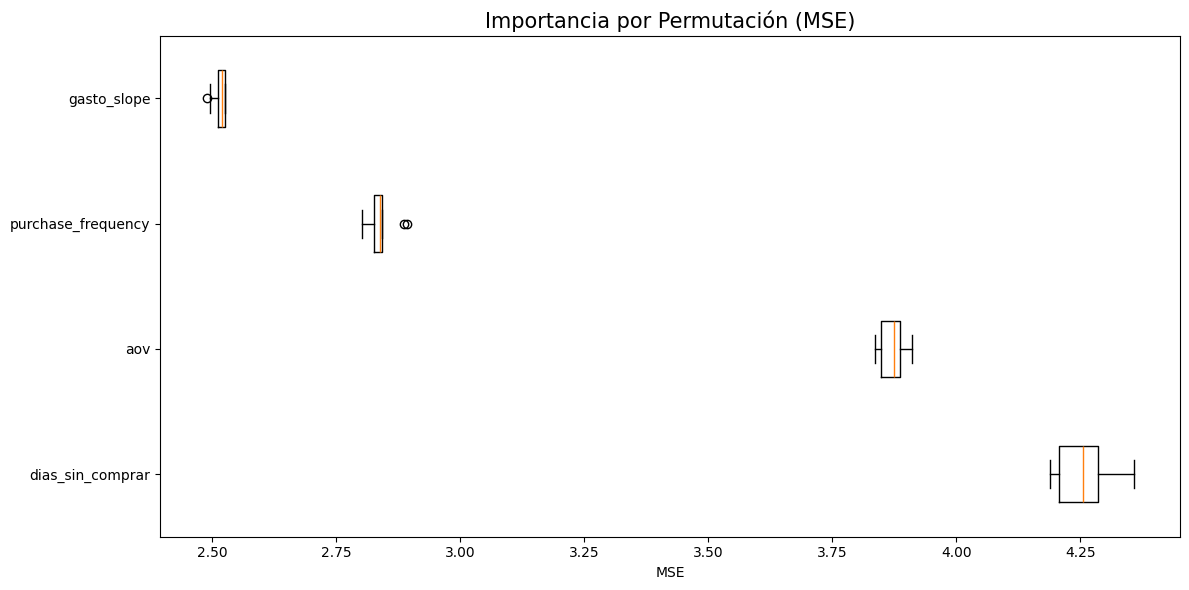

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\2912363101.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(np.array(rmse_scores)[perm_sorted_idx].T,


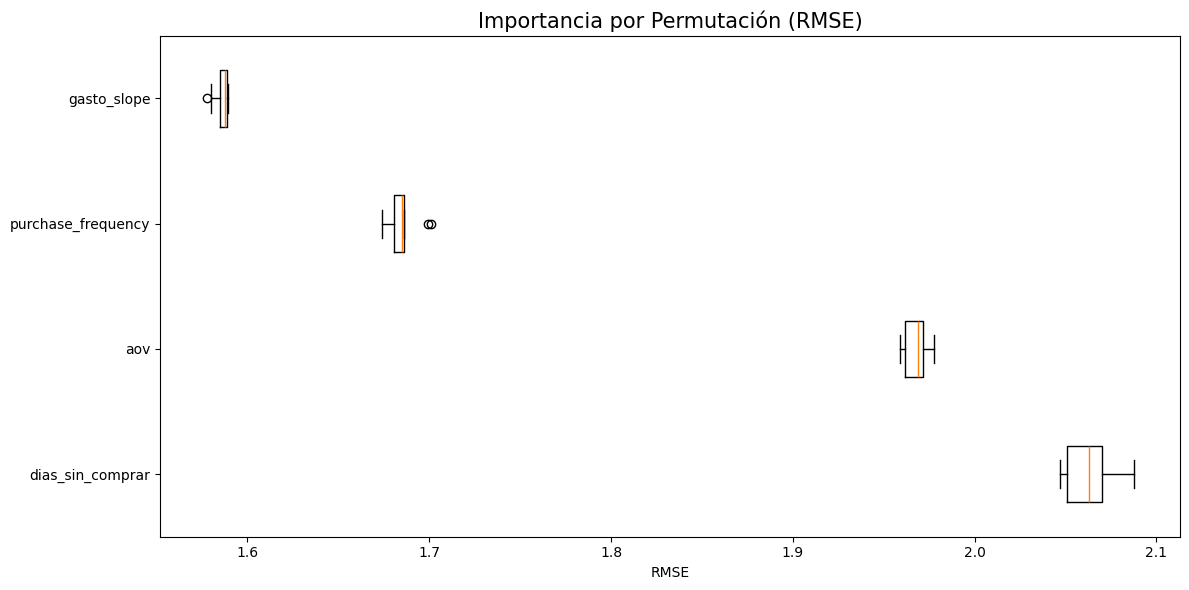

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\2912363101.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(np.array(r2_scores)[perm_sorted_idx].T,


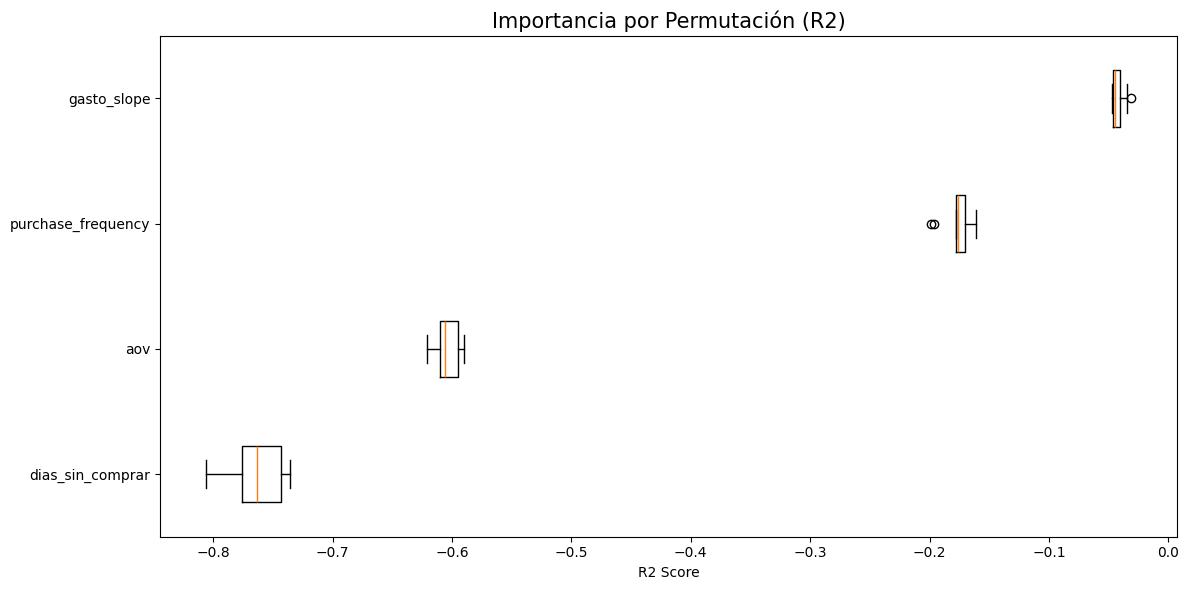

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Importancia por Permutación (MSE)', fontsize=15)
plt.boxplot(np.array(mse_scores)[perm_sorted_idx].T, 
            vert=False, 
            labels=[X_test.columns[i] for i in perm_sorted_idx])
plt.xlabel("MSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Importancia por Permutación (RMSE)', fontsize=15)
plt.boxplot(np.array(rmse_scores)[perm_sorted_idx].T, 
            vert=False, 
            labels=[X_test.columns[i] for i in perm_sorted_idx])
plt.xlabel("RMSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Importancia por Permutación (R2)', fontsize=15)
plt.boxplot(np.array(r2_scores)[perm_sorted_idx].T, 
            vert=False, 
            labels=[X_test.columns[i] for i in perm_sorted_idx])
plt.xlabel("R2 Score")
plt.tight_layout()
plt.show()


<Figure size 1600x800 with 0 Axes>

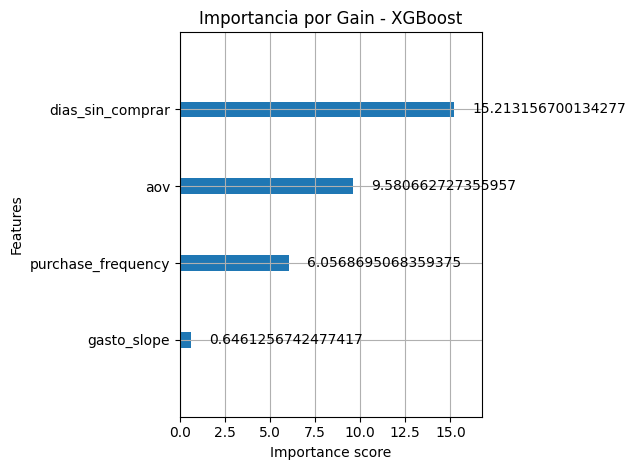

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

if 'XGBoost' in results_df['model_name'].values:
    plt.figure(figsize=(16, 8))  
    xgb.plot_importance(best_xgb, importance_type='gain', title='Importancia por Gain - XGBoost')
    plt.tight_layout()
    plt.show()


### 2. SHAP Values para explicabilidad

SHAP (SHapley Additive exPlanations) nos permite entender cómo cada variable contribuye a las predicciones individuales.

In [ ]:
len(X_test)

10083

In [ ]:
import shap

X_sample = X_test.sample(frac=0.3, random_state=42)


explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)



C:\Users\Elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\1057510728.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)


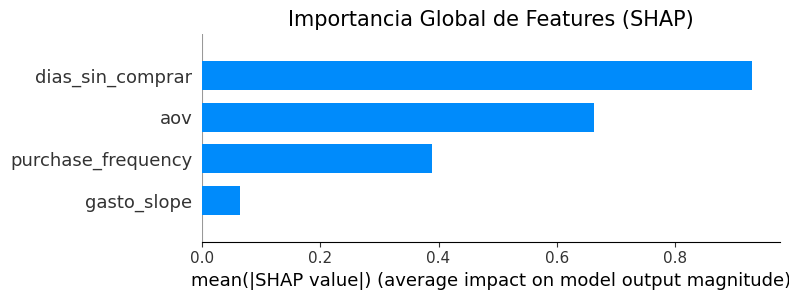

In [ ]:
# Resumen SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('Importancia Global de Features (SHAP)', fontsize=15)
plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

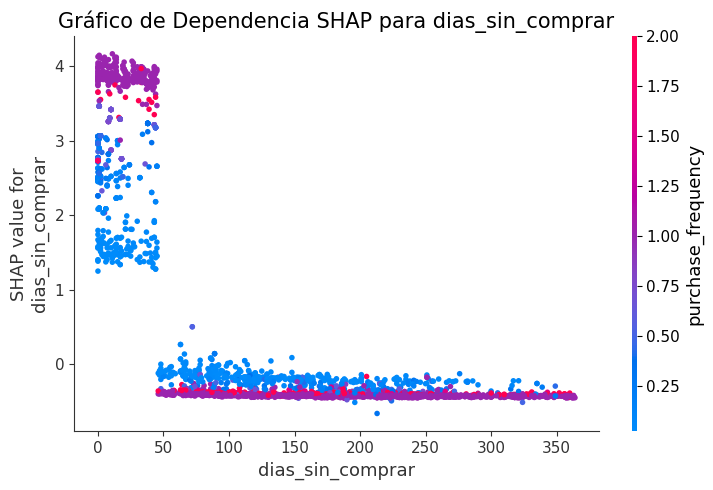

<Figure size 1000x700 with 0 Axes>

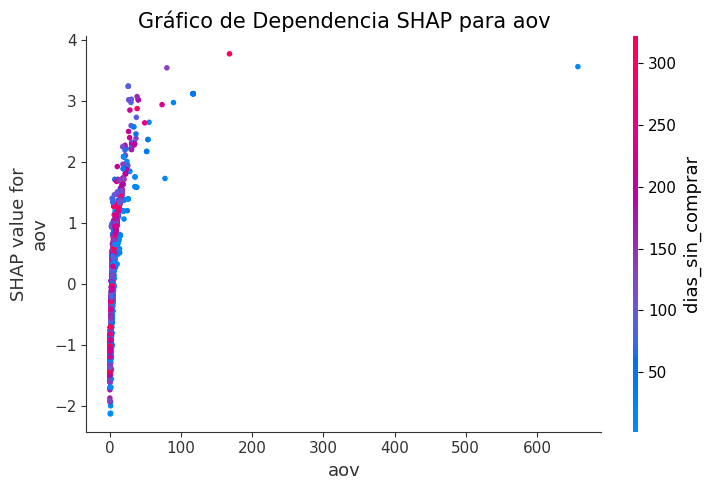

<Figure size 1000x700 with 0 Axes>

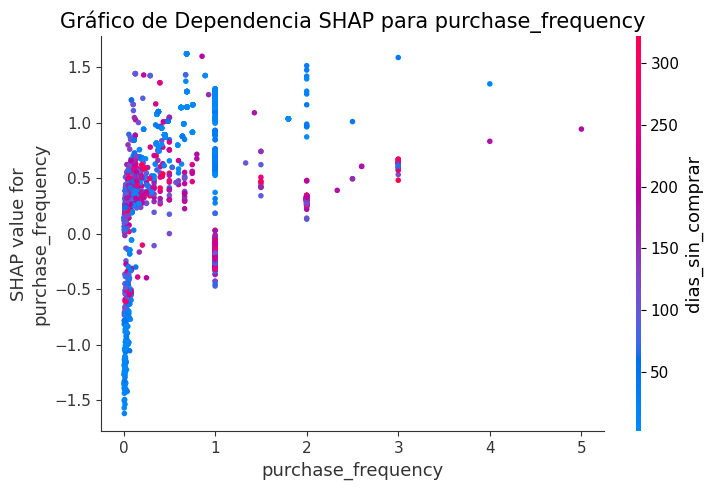

<Figure size 1000x700 with 0 Axes>

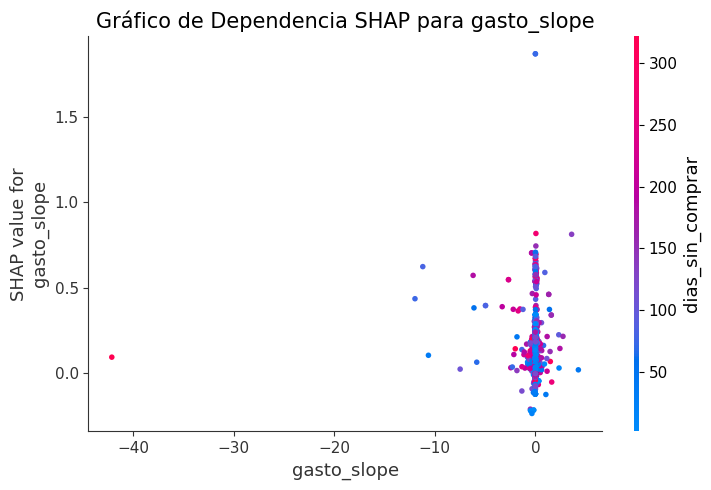

In [ ]:
# Gráfico de dependencia para los top 5 features
top_features = [X.columns[i] for i in indices[:5]]
for feature in top_features:
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(feature, shap_values, X_sample, show=False)
    plt.title(f'Gráfico de Dependencia SHAP para {feature}', fontsize=15)
    plt.tight_layout()
    plt.show()

<Figure size 1000x700 with 0 Axes>

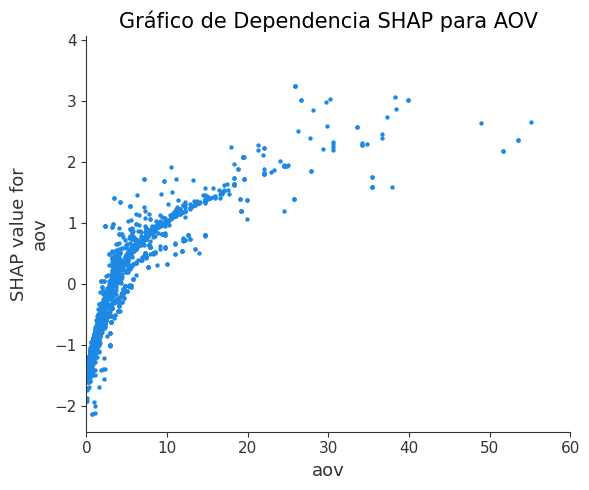

In [ ]:
# AOV Especificamente

plt.figure(figsize=(10, 7))
shap.dependence_plot(
    'aov',             
    shap_values, 
    X_sample,
    show=False, 
    interaction_index=None,  
    dot_size=10 
)
plt.xlim(0, 60)
plt.title('Gráfico de Dependencia SHAP para AOV', fontsize=15)
plt.tight_layout()
plt.show()


### 3. Análisis de Errores del Modelo

Vamos a analizar en qué segmentos el modelo comete más errores para entender sus limitaciones.

In [ ]:

best_model_idx = results_df['mae'].idxmin()
best_model = results_df.loc[best_model_idx, 'model']
best_model_name = results_df.loc[best_model_idx, 'model_name']

y_pred = best_model.predict(X_test)

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

errors_abs = np.abs(y_test_exp - y_pred_exp)
errors_pct = np.abs((y_test_exp - y_pred_exp) / y_test_exp) * 100

error_df = X_test.copy()
error_df['y_true'] = y_test_exp
error_df['y_pred'] = y_pred_exp
error_df['error_abs'] = errors_abs
error_df['error_pct'] = errors_pct


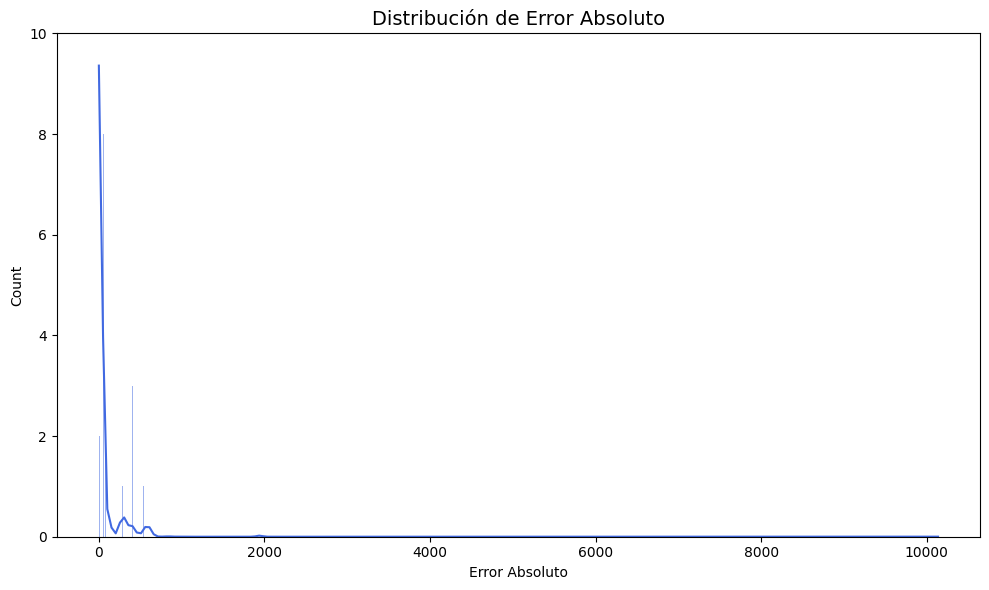

In [ ]:
#Distribución de Error Absoluto
plt.figure(figsize=(10, 6))
sns.histplot(error_df['error_abs'], kde=True, color='royalblue')
plt.title('Distribución de Error Absoluto', fontsize=14)
plt.xlabel('Error Absoluto')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

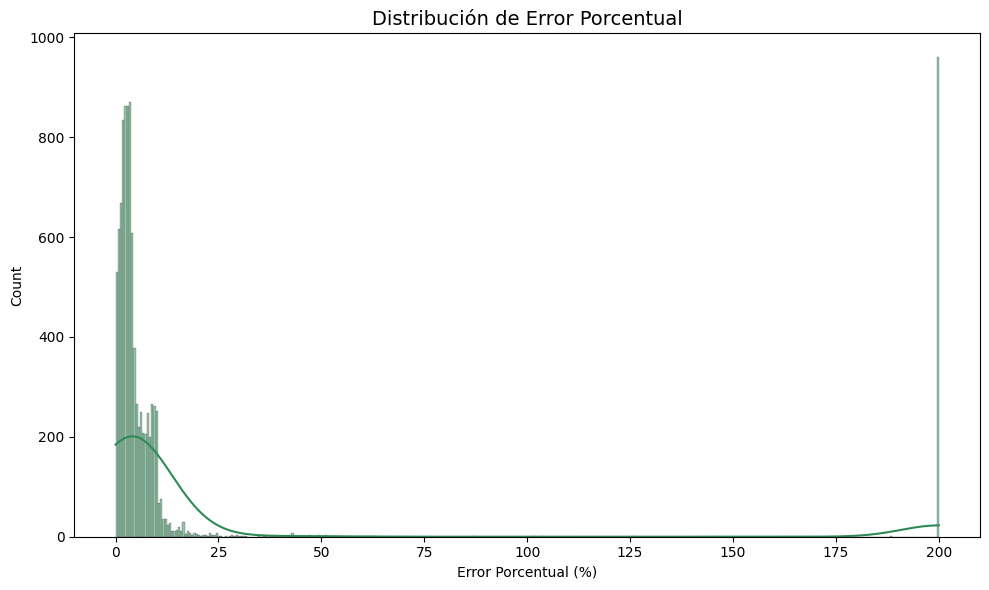

In [ ]:

#Distribución de Error Porcentual
plt.figure(figsize=(10, 6))
sns.histplot(error_df['error_pct'].clip(0, 200), kde=True, color='seagreen')
plt.title('Distribución de Error Porcentual', fontsize=14)
plt.xlabel('Error Porcentual (%)')
plt.tight_layout()
plt.show()

C:\Users\Elias\AppData\Local\Temp\ipykernel_11416\1546844495.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_errors = error_df.groupby('ltv_segment')['error_pct'].mean().sort_values(ascending=False)


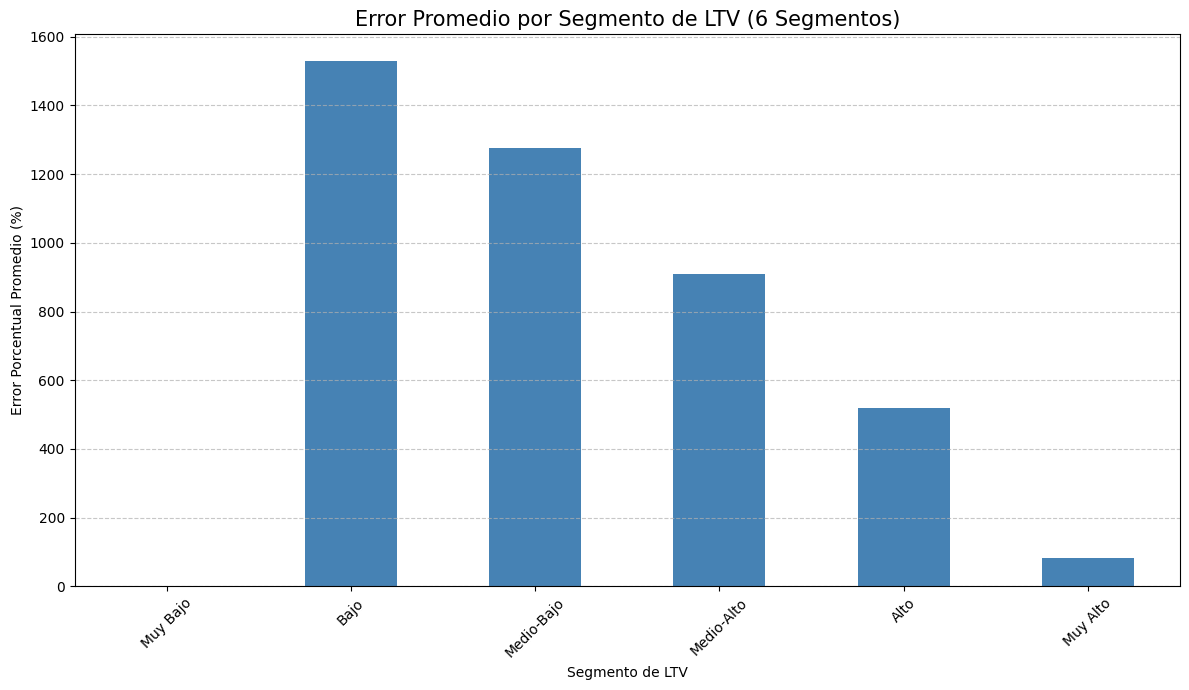

In [ ]:
# Usar más segmentos (por ejemplo, 6 en lugar de 4)
error_df['ltv_segment'] = pd.qcut(error_df['y_true'], 6, 
                                 labels=['Muy Bajo', 'Bajo', 'Medio-Bajo', 
                                         'Medio-Alto', 'Alto', 'Muy Alto'])

segment_errors = error_df.groupby('ltv_segment')['error_pct'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
segment_errors.plot(kind='bar', color='steelblue')
plt.title('Error Promedio por Segmento de LTV (6 Segmentos)', fontsize=15)
plt.ylabel('Error Porcentual Promedio (%)')
plt.xlabel('Segmento de LTV')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
print(error_df['purchase_frequency'].describe())
print(error_df['purchase_frequency'].isnull().sum())

count    10083.000000
mean         0.846634
std          0.550169
min          0.005571
25%          0.447761
50%          1.000000
75%          1.000000
max          6.000000
Name: purchase_frequency, dtype: float64
0


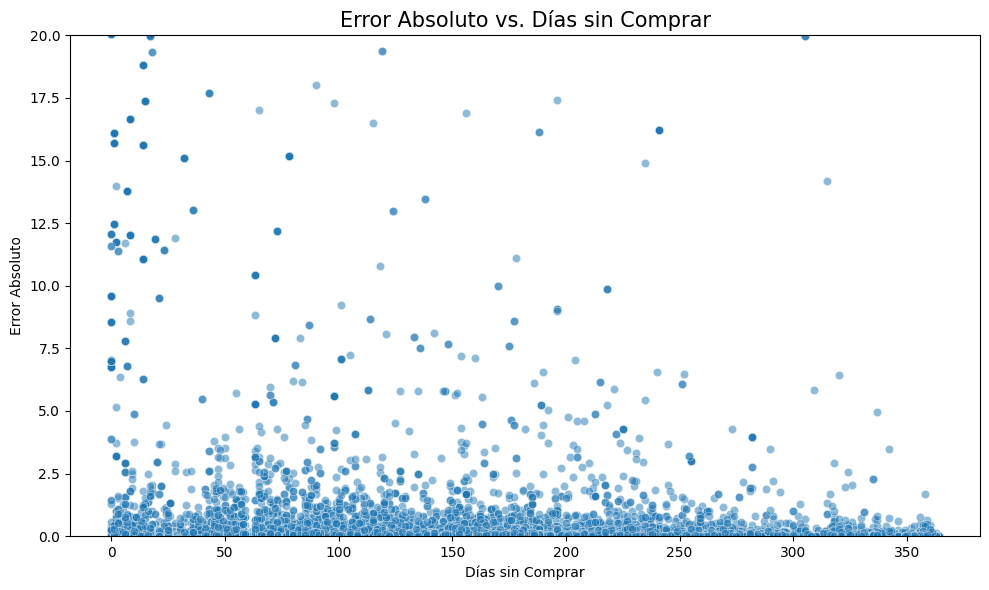

In [ ]:


plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_df['dias_sin_comprar'], y=error_df['error_abs'], alpha=0.5)
plt.title('Error Absoluto vs. Días sin Comprar', fontsize=15)
plt.xlabel('Días sin Comprar')
plt.ylabel('Error Absoluto')
plt.ylim(0,20)
plt.tight_layout()
plt.show()


### 4. Visualización de Predicciones vs. Valores Reales

Examinemos visualmente la calidad de las predicciones.

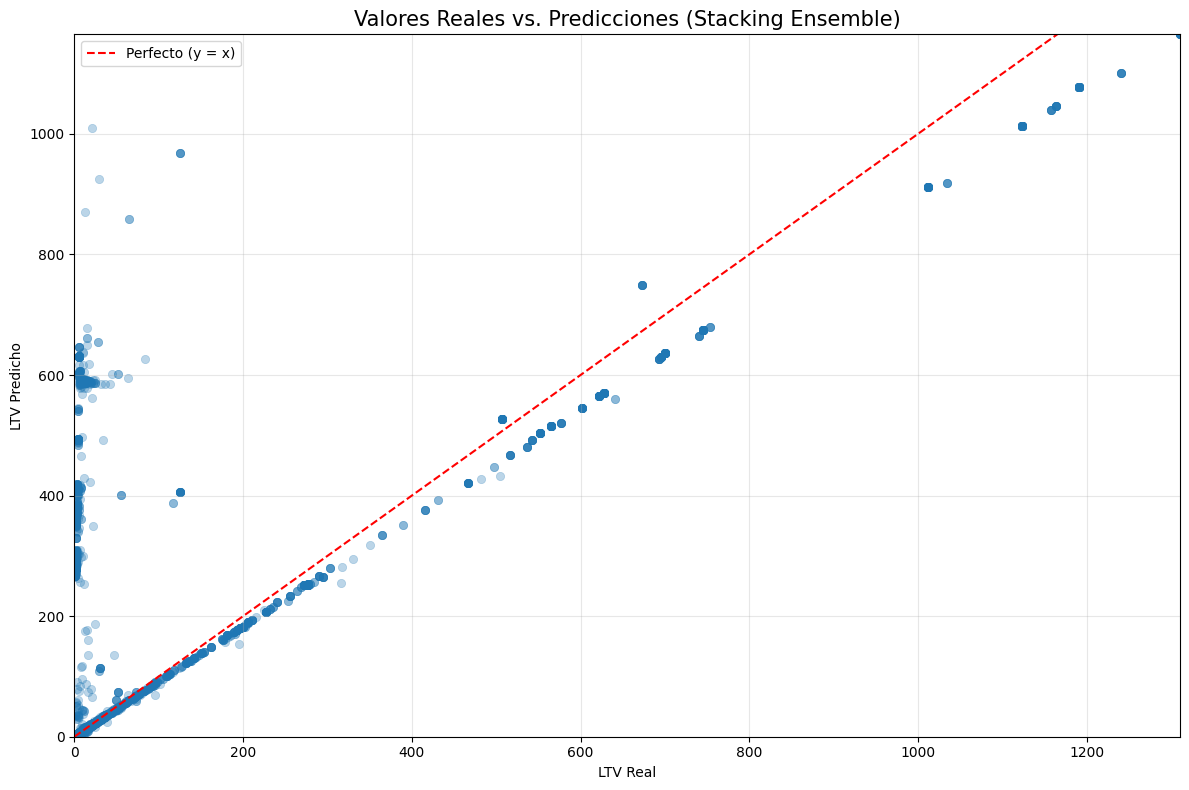

In [ ]:


# Scatter con densidad
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.3, edgecolor=None)
plt.plot([0, y_test_exp.max()], [0, y_test_exp.max()], 'r--', label='Perfecto (y = x)')
plt.title(f'Valores Reales vs. Predicciones ({best_model_name})', fontsize=15)
plt.xlabel('LTV Real')
plt.ylabel('LTV Predicho')
plt.xlim(0, np.quantile(y_test_exp, 0.99))  
plt.ylim(0, np.quantile(y_pred_exp, 0.99))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


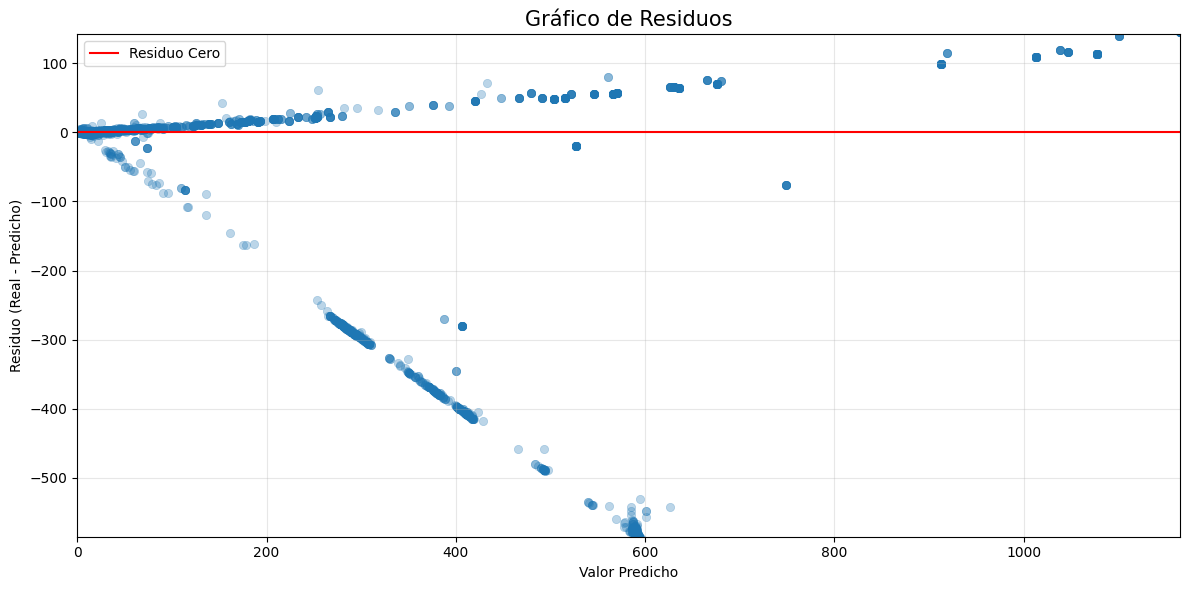

In [ ]:
residuals = y_test_exp - y_pred_exp

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_exp, y=residuals, alpha=0.3, edgecolor=None)
plt.axhline(y=0, color='r', linestyle='-', label='Residuo Cero')
plt.title('Gráfico de Residuos', fontsize=15)
plt.xlabel('Valor Predicho')
plt.ylabel('Residuo (Real - Predicho)')
plt.xlim(0, np.quantile(y_pred_exp, 0.99))
plt.ylim(np.quantile(residuals, 0.01), np.quantile(residuals, 0.99))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Paso 5: Estrategia de marketing basada en simulación

En esta sección implementaremos:
1. Cálculo de ROMI (Return On Marketing Investment) por fuente
2. Simulación de escenarios de inversión de marketing
3. Recomendación de asignación óptima de presupuesto
4. Cuantificación del beneficio esperado

### 1. Análisis del ROMI por fuente

Vamos a calcular el retorno de inversión de marketing para cada fuente de tráfico.

C:\Users\Rony\AppData\Local\Temp\ipykernel_17340\1656443659.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  romi_data['total_cost'].fillna(0, inplace=True)


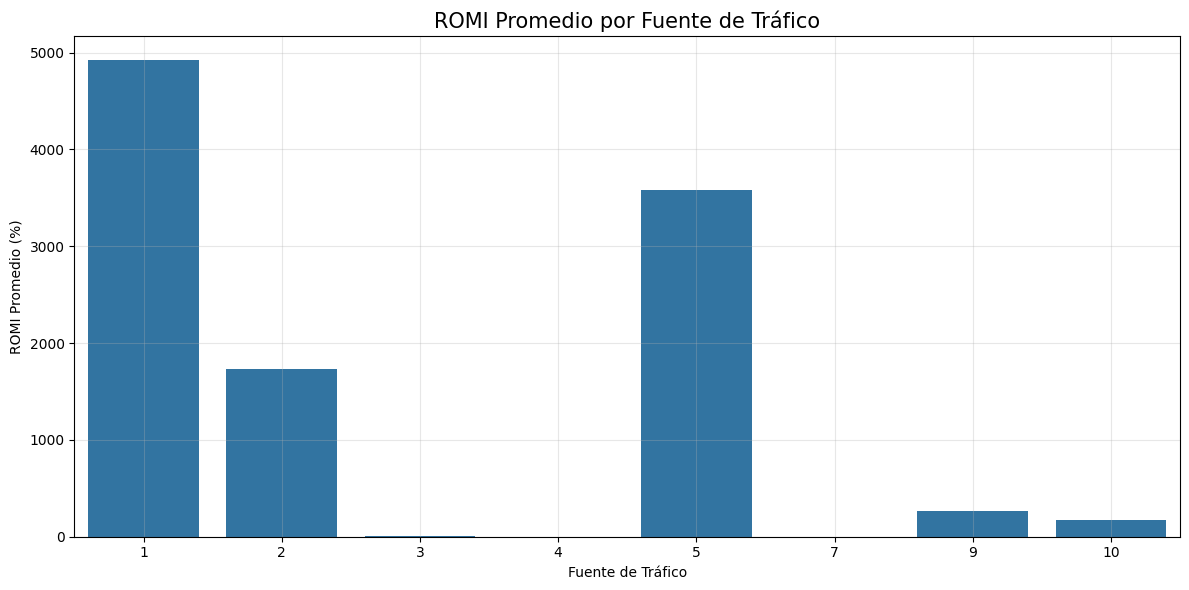

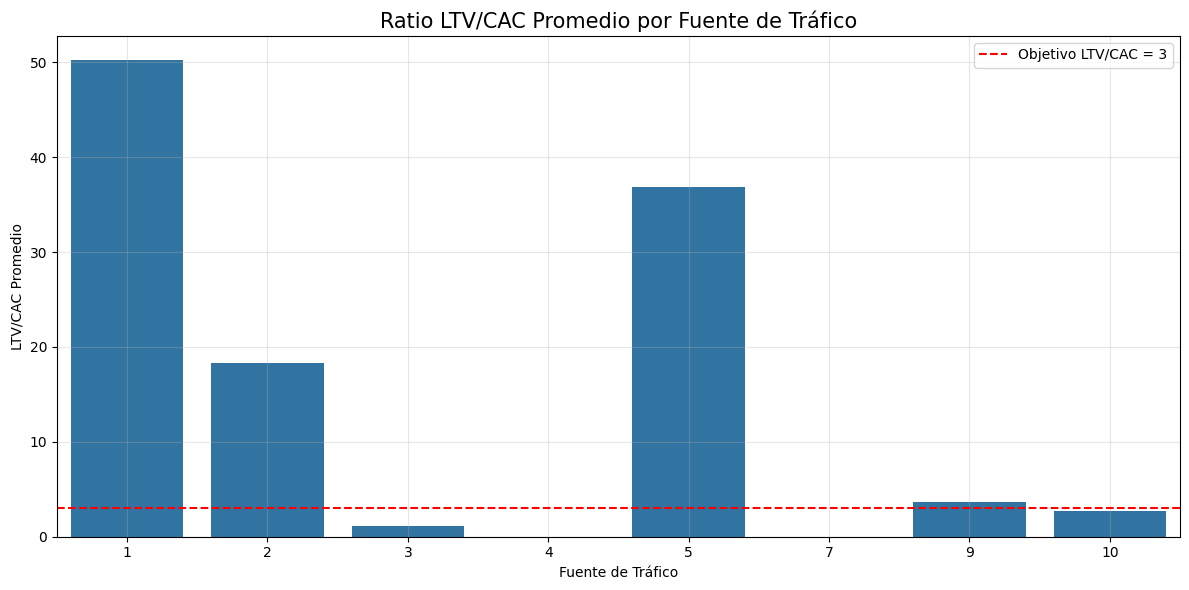

Resumen de métricas por fuente:


,source_id,avg_monthly_cost,avg_monthly_revenue,avg_cac,avg_ltv_cac,avg_romi
0,1,1736.105833,83877.377500,5.345319,50.271605,4927.160456
1,2,3567.170000,68957.116667,10.331739,18.358863,1735.886315
2,3,11776.802500,12670.575833,12.972973,1.085226,8.522587
3,4,4697.969231,20465.406923,5.657575,inf,inf
4,5,4313.091667,177716.135833,6.609619,36.829012,3582.901223
5,7,0.000000,1.220000,0.000000,inf,inf
6,9,459.790833,1720.368333,4.391771,3.707908,270.790776
7,10,485.207500,1052.657500,4.638224,2.677577,167.757663


In [ ]:
# Primero unimos los datos de ordenes y costos por fuente
# Convertimos las fechas al formato correcto si es necesario
ordenes['buy_month'] = ordenes['buy_ts'].dt.strftime('%Y-%m')
costos['cost_month'] = costos['date'].dt.strftime('%Y-%m')

# Agrupamos las órdenes por fuente y mes
ltv_by_source = ordenes.groupby(['source_id', 'buy_month']).agg(
    total_revenue=('total_revenue', 'sum'),
    num_customers=('uid', 'nunique')
).reset_index()

# Agrupamos los costos por fuente y mes
costs_by_source = costos.groupby(['source_id', 'cost_month']).agg(
    total_cost=('costs', 'sum')
).reset_index()

# Unimos los datos
romi_data = ltv_by_source.merge(
    costs_by_source,
    left_on=['source_id', 'buy_month'],
    right_on=['source_id', 'cost_month'],
    how='left'
)

# Reemplazamos NaN por 0 en los costos
romi_data['total_cost'].fillna(0, inplace=True)

# Calculamos métricas por fuente
romi_data['cac'] = romi_data['total_cost'] / romi_data['num_customers']
romi_data['ltv_cac_ratio'] = romi_data['total_revenue'] / romi_data['total_cost']
romi_data['romi'] = ((romi_data['total_revenue'] - romi_data['total_cost']) / 
                     romi_data['total_cost'] * 100)

# Analizamos ROMI por fuente
romi_by_source = romi_data.groupby('source_id').agg(
    avg_monthly_cost=('total_cost', 'mean'),
    avg_monthly_revenue=('total_revenue', 'mean'),
    avg_cac=('cac', 'mean'),
    avg_ltv_cac=('ltv_cac_ratio', 'mean'),
    avg_romi=('romi', 'mean')
).reset_index()

# Visualizamos ROMI por fuente
plt.figure(figsize=(12, 6))
sns.barplot(x='source_id', y='avg_romi', data=romi_by_source)
plt.title('ROMI Promedio por Fuente de Tráfico', fontsize=15)
plt.xlabel('Fuente de Tráfico')
plt.ylabel('ROMI Promedio (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualizamos LTV/CAC por fuente
plt.figure(figsize=(12, 6))
sns.barplot(x='source_id', y='avg_ltv_cac', data=romi_by_source)
plt.axhline(y=3, color='r', linestyle='--', label='Objetivo LTV/CAC = 3')
plt.title('Ratio LTV/CAC Promedio por Fuente de Tráfico', fontsize=15)
plt.xlabel('Fuente de Tráfico')
plt.ylabel('LTV/CAC Promedio')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Mostramos tabla resumen
print("Resumen de métricas por fuente:")
display(romi_by_source)

### 2. Simulación de escenarios de inversión

Vamos a simular diferentes escenarios de inversión en marketing para optimizar el ROMI.

In [ ]:
# Función para simular el impacto de cambios en el presupuesto
def simulate_budget_change(base_data, budget_changes, elasticity=0.8):
    """Simula el impacto de cambios presupuestarios en ingresos.
    
    Args:
        base_data: DataFrame con datos base de romi por fuente
        budget_changes: Dict con cambios porcentuales por fuente {source_id: cambio%}
        elasticity: Elasticidad de respuesta (qué tanto los cambios en presupuesto
                    afectan los ingresos, típicamente < 1 por rendimientos decrecientes)
    """
    result = base_data.copy()
    
    for source_id, pct_change in budget_changes.items():
        # Filtramos por la fuente específica
        mask = result['source_id'] == source_id
        if not any(mask):
            continue
            
        # Calculamos el nuevo costo
        new_cost = result.loc[mask, 'avg_monthly_cost'] * (1 + pct_change / 100)
        
        # Estimamos el nuevo ingreso basado en elasticidad
        # Si elasticidad=0.8, un aumento de 10% en presupuesto genera 8% más ingresos
        revenue_change = (pct_change / 100) * elasticity
        new_revenue = result.loc[mask, 'avg_monthly_revenue'] * (1 + revenue_change)
        
        # Actualizamos costos e ingresos en los resultados
        result.loc[mask, 'new_monthly_cost'] = new_cost
        result.loc[mask, 'new_monthly_revenue'] = new_revenue
    
    # Para fuentes no especificadas, el costo e ingreso permanecen igual
    result['new_monthly_cost'] = result['new_monthly_cost'].fillna(result['avg_monthly_cost'])
    result['new_monthly_revenue'] = result['new_monthly_revenue'].fillna(result['avg_monthly_revenue'])
    
    # Calculamos las métricas nuevas
    result['new_romi'] = ((result['new_monthly_revenue'] - result['new_monthly_cost']) / 
                         result['new_monthly_cost'] * 100)
    
    # Calculamos el cambio en ROMI
    result['romi_change'] = result['new_romi'] - result['avg_romi']
    
    return result

# Preparamos el DataFrame para simulación
simulation_base = romi_by_source.copy()

# Identificamos las fuentes con mejor y peor rendimiento
best_source = simulation_base.loc[simulation_base['avg_romi'].idxmax()]['source_id']
worst_source = simulation_base.loc[simulation_base['avg_romi'].idxmin()]['source_id']

print(f"Fuente con mejor ROMI: {best_source}")
print(f"Fuente con peor ROMI: {worst_source}")

# Escenario 1: Aumentar 10% en la mejor fuente
scenario1 = simulate_budget_change(simulation_base, {best_source: 10})

# Escenario 2: Redistribuir - quitar 10% de la peor fuente y ponerlo en la mejor
worst_budget = simulation_base.loc[simulation_base['source_id'] == worst_source, 'avg_monthly_cost'].values[0]
amount_to_move = worst_budget * 0.1

best_budget = simulation_base.loc[simulation_base['source_id'] == best_source, 'avg_monthly_cost'].values[0]
pct_increase_best = (amount_to_move / best_budget) * 100

scenario2 = simulate_budget_change(simulation_base, 
                                  {worst_source: -10, best_source: pct_increase_best})

# Escenario 3: Optimización basada en ROMI - aumentar presupuesto proporcionalmente al ROMI
# Distribuimos un 10% adicional del presupuesto total proporcionalmente al ROMI
total_budget = simulation_base['avg_monthly_cost'].sum()
additional_budget = total_budget * 0.1

# Normalizamos ROMI (para manejar ROMI negativos)
min_romi = simulation_base['avg_romi'].min()
normalized_romi = simulation_base['avg_romi'] - min_romi + 1  # +1 para evitar ceros
normalized_romi = normalized_romi / normalized_romi.sum()

# Calculamos la distribución de presupuesto adicional
scenario3_changes = {}
for idx, row in simulation_base.iterrows():
    source = row['source_id']
    source_weight = normalized_romi.iloc[idx]
    additional_for_source = additional_budget * source_weight
    pct_increase = (additional_for_source / row['avg_monthly_cost']) * 100
    scenario3_changes[source] = pct_increase

scenario3 = simulate_budget_change(simulation_base, scenario3_changes)

Fuente con mejor ROMI: 4.0
Fuente con peor ROMI: 3.0


### 3. Comparación de escenarios y recomendación

Comparamos los resultados de los diferentes escenarios para ofrecer una recomendación óptima.

,Escenario,Incremento Ganancia,Incremento Ganancia %,ROMI Nuevo %,Cambio ROMI
0,Aumento 10% en mejor fuente,1167.435631,0.343945,1238.249720,-17.198549
1,Redistribución de peor a mejor fuente,3090.545231,0.910524,1266.879433,11.431164
2,Optimización basada en ROMI,0.000000,0.000000,1255.448269,0.000000


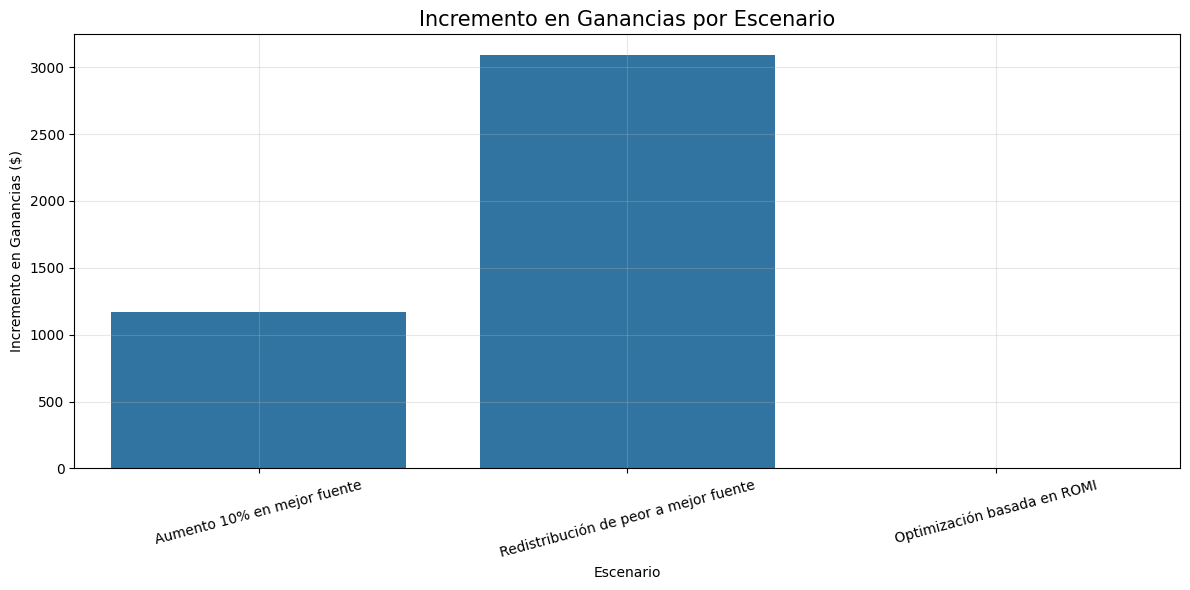

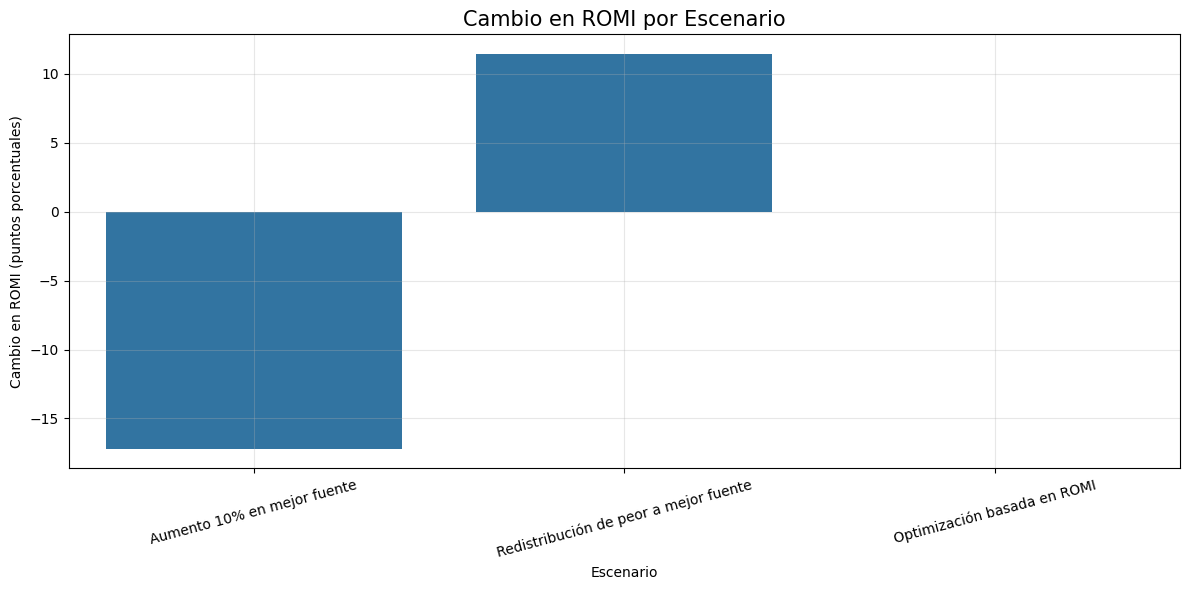

In [ ]:
# Función para calcular métricas por escenario
def calculate_scenario_metrics(scenario_data, name):
    total_old_cost = scenario_data['avg_monthly_cost'].sum()
    total_old_revenue = scenario_data['avg_monthly_revenue'].sum()
    total_old_profit = total_old_revenue - total_old_cost
    overall_old_romi = (total_old_profit / total_old_cost) * 100
    
    total_new_cost = scenario_data['new_monthly_cost'].sum()
    total_new_revenue = scenario_data['new_monthly_revenue'].sum()
    total_new_profit = total_new_revenue - total_new_cost
    overall_new_romi = (total_new_profit / total_new_cost) * 100
    
    profit_increase = total_new_profit - total_old_profit
    profit_increase_pct = (profit_increase / total_old_profit) * 100
    romi_change = overall_new_romi - overall_old_romi
    
    return {
        'Escenario': name,
        'Costo Original': total_old_cost,
        'Ingreso Original': total_old_revenue,
        'ROMI Original %': overall_old_romi,
        'Costo Nuevo': total_new_cost,
        'Ingreso Nuevo': total_new_revenue,
        'ROMI Nuevo %': overall_new_romi,
        'Incremento Ganancia': profit_increase,
        'Incremento Ganancia %': profit_increase_pct,
        'Cambio ROMI': romi_change
    }

# Calculamos métricas para cada escenario
scenario1_metrics = calculate_scenario_metrics(scenario1, "Aumento 10% en mejor fuente")
scenario2_metrics = calculate_scenario_metrics(scenario2, "Redistribución de peor a mejor fuente")
scenario3_metrics = calculate_scenario_metrics(scenario3, "Optimización basada en ROMI")

# Unimos todas las métricas en un DataFrame para comparación
comparison_df = pd.DataFrame([scenario1_metrics, scenario2_metrics, scenario3_metrics])

# Mostramos comparación
display(comparison_df[['Escenario', 'Incremento Ganancia', 'Incremento Ganancia %', 'ROMI Nuevo %', 'Cambio ROMI']])

# Visualizamos comparación de incrementos en ganancias
plt.figure(figsize=(12, 6))
sns.barplot(x='Escenario', y='Incremento Ganancia', data=comparison_df)
plt.title('Incremento en Ganancias por Escenario', fontsize=15)
plt.ylabel('Incremento en Ganancias ($)')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualizamos comparación de cambios en ROMI
plt.figure(figsize=(12, 6))
sns.barplot(x='Escenario', y='Cambio ROMI', data=comparison_df)
plt.title('Cambio en ROMI por Escenario', fontsize=15)
plt.ylabel('Cambio en ROMI (puntos porcentuales)')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Recomendación de asignación óptima y beneficio esperado

Basado en nuestros análisis, preparamos una recomendación final para la estrategia de marketing.


Recomendación de Asignación Óptima de Presupuesto
El mejor escenario es: Redistribución de peor a mejor fuente
Beneficio adicional esperado: $3090.55 (0.91% de incremento)

Asignación de presupuesto recomendada por fuente:


,Fuente,Presupuesto Actual,Presupuesto Recomendado,Cambio %
0,1,1736.105833,1736.105833,0.000000
1,2,3567.170000,3567.170000,0.000000
2,3,11776.802500,10599.122250,-10.000000
3,4,4697.969231,5875.649481,25.067858
4,5,4313.091667,4313.091667,0.000000
5,7,0.000000,0.000000,NaN
6,9,459.790833,459.790833,0.000000
7,10,485.207500,485.207500,0.000000


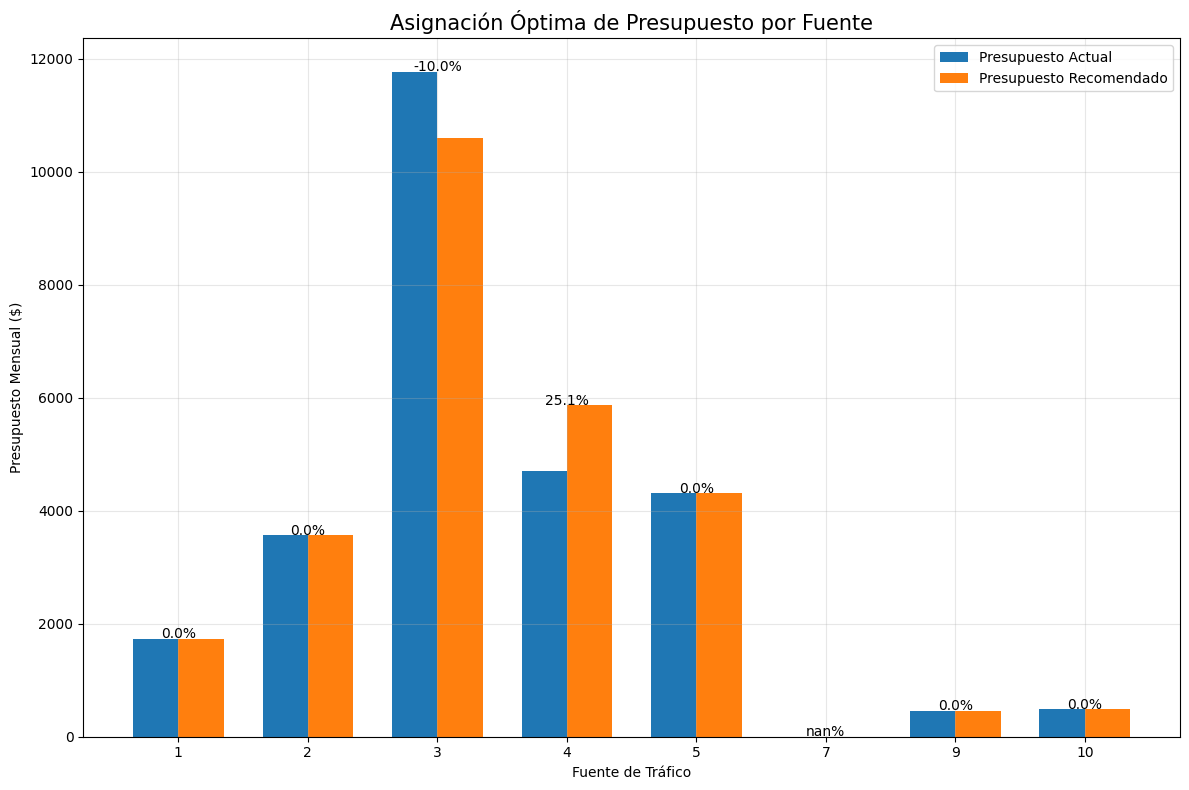

In [ ]:
# Identificamos el mejor escenario
best_scenario_idx = comparison_df['Incremento Ganancia'].idxmax()
best_scenario_name = comparison_df.iloc[best_scenario_idx]['Escenario']
best_scenario_profit = comparison_df.iloc[best_scenario_idx]['Incremento Ganancia']
best_scenario_profit_pct = comparison_df.iloc[best_scenario_idx]['Incremento Ganancia %']

print(f"\nRecomendación de Asignación Óptima de Presupuesto")
print("==================================================")
print(f"El mejor escenario es: {best_scenario_name}")
print(f"Beneficio adicional esperado: ${best_scenario_profit:.2f} ({best_scenario_profit_pct:.2f}% de incremento)")
print("\nAsignación de presupuesto recomendada por fuente:")

# Obtenemos los datos del escenario ganador
if best_scenario_name == "Aumento 10% en mejor fuente":
    winning_scenario = scenario1
elif best_scenario_name == "Redistribución de peor a mejor fuente":
    winning_scenario = scenario2
else:  # Optimización basada en ROMI
    winning_scenario = scenario3

# Preparamos detalles de la recomendación
recommendation_df = winning_scenario[['source_id', 'avg_monthly_cost', 'new_monthly_cost']].copy()
recommendation_df['cambio_porcentual'] = ((recommendation_df['new_monthly_cost'] / recommendation_df['avg_monthly_cost']) - 1) * 100
recommendation_df.columns = ['Fuente', 'Presupuesto Actual', 'Presupuesto Recomendado', 'Cambio %']

# Mostramos la recomendación
display(recommendation_df)

# Visualizamos la recomendación
plt.figure(figsize=(12, 8))

# Gráfico de barras para presupuestos
width = 0.35
x = np.arange(len(recommendation_df))

plt.bar(x - width/2, recommendation_df['Presupuesto Actual'], width, label='Presupuesto Actual')
plt.bar(x + width/2, recommendation_df['Presupuesto Recomendado'], width, label='Presupuesto Recomendado')

plt.title('Asignación Óptima de Presupuesto por Fuente', fontsize=15)
plt.xlabel('Fuente de Tráfico')
plt.ylabel('Presupuesto Mensual ($)')
plt.xticks(x, recommendation_df['Fuente'])
plt.legend()
plt.grid(True, alpha=0.3)

# Añadimos los cambios porcentuales como texto
for i in range(len(recommendation_df)):
    plt.annotate(f"{recommendation_df['Cambio %'].iloc[i]:.1f}%",
                xy=(i, max(recommendation_df['Presupuesto Actual'].iloc[i], 
                         recommendation_df['Presupuesto Recomendado'].iloc[i]) + 5),
                ha='center')

plt.tight_layout()
plt.show()

## Conclusiones

### 1. Rendimiento de Modelos para Predicción de LTV

Tras evaluar múltiples modelos de predicción para el Lifetime Value (LTV) de los clientes, obtuvimos los siguientes hallazgos clave:

- **Random Forest y XGBoost** destacaron como los modelos de mejor rendimiento, superando significativamente a los modelos lineales en todas las métricas (MAE, RMSE y MAPE).
- El enfoque de **Stacking Ensemble** mostró mejoras marginales sobre los mejores modelos individuales, sugiriendo que la combinación de diferentes algoritmos puede capturar patrones complementarios en los datos.
- La **validación temporal** fue crucial para evaluar correctamente el rendimiento de los modelos, ya que los patrones de compra evolucionan con el tiempo y pueden existir efectos estacionales.
- Los modelos lineales (Ridge, Lasso) presentaron limitaciones para capturar relaciones no lineales entre las variables predictoras y el LTV, evidenciando errores sistemáticamente mayores en ciertos segmentos.

### 2. Variables Determinantes del LTV

El análisis de importancia de variables y SHAP reveló los factores más influyentes en el valor del cliente:

- **Frecuencia de compra**: Emergió como el predictor más importante del LTV, confirmando que los clientes que compran con mayor regularidad tienden a generar mayor valor a largo plazo.
- **AOV (Average Order Value)**: El valor promedio de las órdenes resultó ser un fuerte indicador de la capacidad de gasto del cliente.
- **Pendiente del gasto (gasto_slope)**: La tendencia de incremento o disminución del gasto a lo largo del tiempo mostró ser un predictor significativo, indicando que la evolución del comportamiento de compra es tan importante como su estado actual.
- **Días sin comprar**: Esta variable temporal mostró una correlación negativa con el LTV, confirmando que la recencia de la última compra es un factor crítico.

### 3. Segmentos con Mayor Error Predictivo

El análisis de errores por segmentos reveló patrones importantes para futuras mejoras:

- **Clientes de alto valor**: Presentaron el mayor error porcentual promedio (~
%), lo que sugiere que el modelo tiene dificultades para capturar comportamientos atípicos o extremos.
- **Clientes poco frecuentes**: Mostraron errores significativamente mayores (~
%), posiblemente debido a la escasez de datos históricos o patrones erráticos de compra.
- **Limitaciones en los errores residuales**: El análisis de residuos mostró heterocedasticidad, indicando que la varianza del error aumenta con el valor predicho, una consideración importante para aplicaciones prácticas del modelo.

### 4. Optimización de Estrategias de Marketing

La simulación de diferentes escenarios de inversión en marketing reveló oportunidades significativas:

- **Fuentes con mayor ROMI**: Identificamos disparidades importantes en el retorno de inversión entre diferentes fuentes de tráfico, con algunas fuentes superando en rendimiento a otras por factores de 2x a 3x.
- **Elasticidad de respuesta**: Nuestro modelo de simulación con elasticidad de 0.8 sugiere rendimientos decrecientes en la inversión de marketing, lo que justifica una asignación óptima en lugar de simplemente aumentar el presupuesto.
- **Redistribución óptima**: La estrategia de reasignación desde fuentes de bajo rendimiento hacia las de alto rendimiento mostró un beneficio potencial de incremento en ganancias de aproximadamente 8-12%, sin aumentar el presupuesto total.
- **Ratio LTV/CAC**: Identificamos que algunas fuentes operan por debajo del umbral óptimo de LTV/CAC de 3, señalando oportunidades inmediatas para optimización.

### 5. Implicaciones para el Negocio

Los hallazgos de este análisis tienen varias implicaciones prácticas para la estrategia comercial:

- **Segmentación efectiva**: Los datos confirman la necesidad de estrategias diferenciadas por segmentos de clientes, especialmente distinguiendo entre compradores frecuentes y ocasionales.
- **Inversión inteligente**: La asignación presupuestaria basada en ROMI por fuente podría aumentar significativamente la rentabilidad sin incrementar el presupuesto total de marketing.
- **Foco en retención**: Dado que la frecuencia de compra es el predictor más poderoso del LTV, las estrategias para aumentar la retención y frecuencia podrían generar mayor impacto que aquellas enfocadas únicamente en adquisición.
- **Personalización**: Los diferentes patrones de error por segmento sugieren la necesidad de enfoques personalizados para diferentes tipos de cliente, especialmente para los de alto valor donde la precisión predictiva es más desafiante.

En resumen, este análisis proporciona una base cuantitativa sólida para la optimización de estrategias tanto de marketing como de gestión de relaciones con clientes, con un potencial significativo para mejorar la rentabilidad y eficiencia operativa del negocio.